# Import packages

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import torch
from torch.optim import Adam
import scipy.stats as stat
from scipy.stats import multivariate_normal
import sbi
import lsbi
from lsbi.network import BinaryClassifierLPop, BinaryClassifier
import math
import sys
import pickle
from datetime import datetime
import IPython
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, HBox, VBox
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider
from torch import nn

In [3]:
De = pd.read_csv('/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv')


De_mass_list = De["Mass [GeV]"]
De_event_list = De["Events/10 GeV"]

De_mass = []
De_event = []

for i,elem in enumerate(De_mass_list):
    De_mass.append(De_mass_list[i])
    De_event.append(De_event_list[i])

De_mass = np.array(De_mass)
De_event = np.array(De_event)

yerr = np.sqrt(De_event)

# Load and process data (if not specified it means for stats analysis)

In [3]:
# Define events as number of events total, this is the realy experimental data, not events per bin

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Mass [GeV] LOW", "Mass [GeV] HIGH", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_events_scaled = (De["Mass [GeV] HIGH"].values - De["Mass [GeV] LOW"].values) * De["Events/10 GeV"].values
    De_events_scaled_min = min([i for i in De_events_scaled if i != 0])
    De_event = De_events_scaled / De_events_scaled_min
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

# Load and process data (for curve fit and plotting)

In [4]:
def load_and_process_data_plotting(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Mass [GeV] LOW", "Mass [GeV] HIGH", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

# Load and process data for plot checking

This is to check whether the Bayes factor is accurate  by seeing how each model optimises. If the Bayes factor comes out close to zero then we cna check this by seeing if both models optimise to similar losses.

In [5]:
def load_and_process_data_plot_check(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Mass [GeV] LOW", "Mass [GeV] HIGH", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    return De_mass

# Checking stats scatter graph

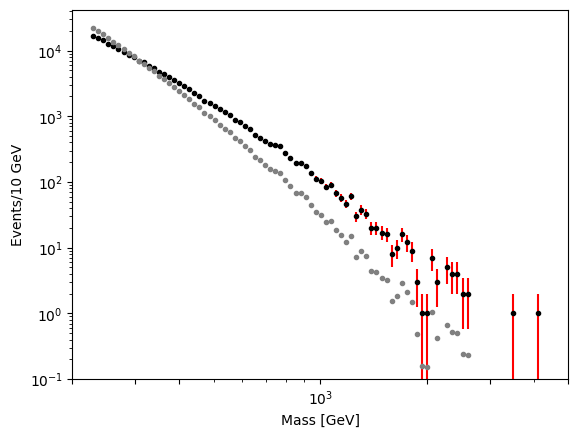

In [6]:
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
De_mass, De_event, yerr = load_and_process_data(data_path)
De_mass_paper, De_event_paper, yerr_paper = load_and_process_data_plotting(data_path)

plt.errorbar(De_mass, De_event, yerr = yerr, fmt = '.', color = 'black', ecolor = 'red')
plt.errorbar(De_mass_paper, De_event_paper, fmt = '.', color = 'grey')
plt.xlim(0,4000)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Mass [GeV]")
plt.ylabel("Events/10 GeV")
plt.xlim(200, 4000)
plt.ylim(10**-1)
plt.xticks([200, 300, 400, 1000, 2000, 3000, 5000])
plt.show()

# Plot curve (using paper parameters and scatter date, not useful comparison)

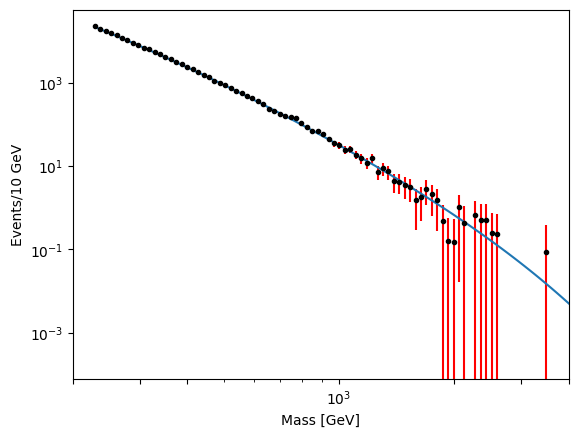

In [17]:
data_path = "/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv"
De_mass, De_event, yerr = load_and_process_data_plotting(data_path)

x_me = De_mass/13000
c_e = 1
a = 178000
b = 1.5
p0 = -12.38
p1 = -4.295
p2 = -0.9191
p3 = -0.0845
gamma = 2.4952
mz = 91.1876
# BW = (1/(2*np.pi)) + gamma/((De_mass - mz)**2 + (gamma**2)/4)
# BW1 = 1/((De_mass - mz)**2 + (gamma**2)/4)
BW2 = gamma / ((x_me*13000 - mz) ** 2 + gamma**2 / 4)

# curve = 178000/(np.trapz(De_event, De_mass)) * BW * ((1-x**(c_e))**b) * x ** (p0*(np.log10(x))**0 + p1*(np.log10(x)**1) + p2*(np.log10(x)**2) + p3*(np.log10(x))**3)
curve = BW2 * ((1-x_me**(c_e))**b) * x_me ** (p0*(np.log(x_me))**0 + p1*(np.log(x_me)**1) + p2*(np.log(x_me)**2) + p3*(np.log(x_me)**3))
norm = a/curve.sum(axis=-1)
curve1 = norm*curve
# print(f"{np.sum(De_event)}")

plt.errorbar(De_mass, De_event, yerr = yerr, fmt = '.', color = 'black', ecolor = 'red')
plt.plot(De_mass, curve1)
plt.xlim(0,4000)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Mass [GeV]")
plt.ylabel("Events/10 GeV")
plt.xlim(200, 4000)
plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
plt.show()

# Note: Calculate AIC

# Torch optimisation from agnostic prior distribution i = 2 (using stats data)

Initial Loss = 37.84922790527344
Final loss before filter = 4.328188419342041
Initial Loss = 29.187286376953125
Final loss before filter = 5.16933536529541
Initial Loss = 39.73699951171875
Final loss before filter = 4.557640075683594
Initial Loss = 37.37614059448242
Final loss before filter = 7.205632209777832
Initial Loss = 36.33749008178711
Final theta = tensor([ 1.7625e+05, -2.1118e+00, -1.2244e+01, -2.5028e+00, -1.5959e-01]), Final loss = 3.9323418140411377, Number of iterations = 10000


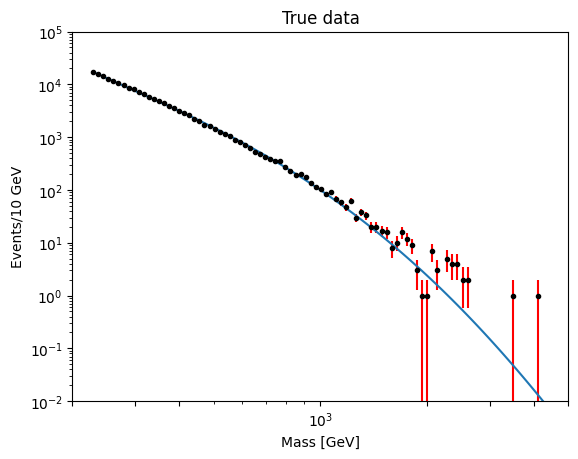

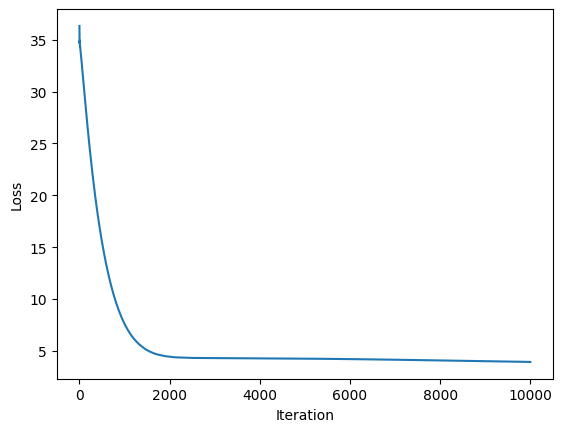

In [55]:
# By default optim_p2_poisson contains N = 10000 with loss filter of 4.2 and N filter = 4000

class optim_p2_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95], high=[1.9 * 10**5, 5, -11.5, -4, -0.45])

    def curve_torch_2(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 40

    def adjust_theta_2(self, y_pred_2):
        while not self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_2

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 10000
            loss_crit = 1.5
            loss_filter = 4.3
            N_iter_filter = 4000
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            plt.errorbar(self.De_mass, self.De_event, yerr=self.yerr, fmt='.', color='black', ecolor='red')
            y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            plt.plot(self.De_mass, y_pred_2_plot)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 5000)
            plt.ylim(bottom=10**-2, top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 5000])
            plt.title("True data")
            plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_2_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")

            f_loss,a_loss = plt.subplots()
            a_loss.plot(losses)
            # a_loss.set_yscale("log")
            a_loss.set_ylabel("Loss")
            a_loss.set_xlabel("Iteration")
            # a_loss.set_xlim(N_iter-1000, N_iter)
            # a_loss.set_ylim(0.55, 0.6)

# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

optimizer_class = optim_p2_poisson(data_path)
optimizer_class.run()

# Torch optimisation from agnostic prior distributions i = 3 (using stats data)

Initial Loss = 6.816856861114502
Final loss before filter = 6.6284565925598145
Initial Loss = 23.060443878173828
Final loss before filter = 5.807314395904541
Initial Loss = 24.062917709350586
Final loss before filter = 6.4264702796936035
Initial Loss = 7.6453728675842285
Final loss before filter = 6.277777671813965
Initial Loss = 15.497140884399414
Final loss before filter = 5.026464462280273
Initial Loss = 5.04295539855957
Final loss before filter = 3.5354464054107666
Initial Loss = 7.041013240814209
Final loss before filter = 6.2120466232299805
Initial Loss = 3.833573818206787
Final loss before filter = 3.6943962574005127
Initial Loss = 7.220810413360596
Final loss before filter = 4.38853645324707
Initial Loss = 17.828035354614258
Final theta = tensor([ 1.7849e+05,  1.3199e+00, -1.1987e+01, -4.1287e+00, -8.0134e-01,
        -6.9689e-02]), Final loss = 3.3628933429718018, Number of iterations = 1400


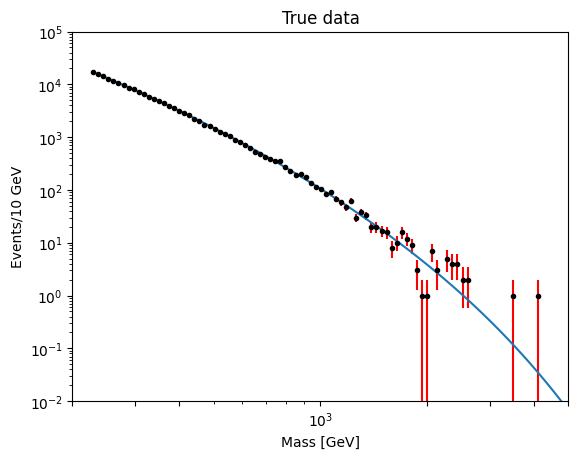

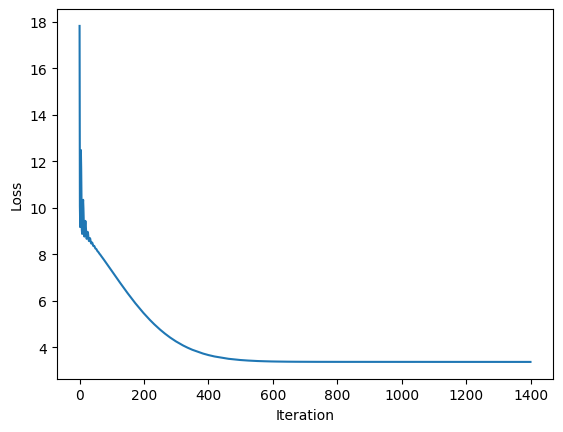

In [7]:
# By default optim_p3_poisson contains N = 1400 with loss filter of 3.37 and N filter = 1000

class optim_p3_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        # print(f"Norm = {norm_ft}")
        # print(f"Base function = {((1 - x ** self.c_e_ft) ** b_ft)}")
        # print(f"X function = {x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)}")
        # print(f"BW2 = {BW2}")
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 3.37
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    print(f"Final loss before filter = {losses[-1]}")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            plt.errorbar(self.De_mass, self.De_event, yerr=self.yerr, fmt='.', color='black', ecolor='red')
            y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            plt.plot(self.De_mass, y_pred_3_plot)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 5000)
            plt.ylim(bottom = 10**-2, top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 5000])
            plt.title("True data")
            plt.show()

            f_loss,a_loss = plt.subplots()
            a_loss.plot(losses)
            # a_loss.set_yscale("log")
            a_loss.set_ylabel("Loss")
            a_loss.set_xlabel("Iteration")
            # a_loss.set_xlim(N_iter-1000, N_iter)
            # a_loss.set_ylim(0.55, 0.6)


# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

optimizer_class = optim_p3_poisson(data_path)
optimizer_class.run()

# for j in range(5):
#     losses_to_avg = []
#     for i in range (60):
#         optimizer_class = optim_p3_poisson(data_path)
#         optimizer_class.run()

#         losses_array = optimizer_class.losses
#         final_loss = losses_array[-1]
#         losses_to_avg.append(final_loss)
#     print(f"Average loss = {np.mean(losses_to_avg)}")

# Torch optimisation from agnostic prior distributions i = 4 (using stats data)

Initial Loss = 9.990507125854492
Final loss before filter = 4.454708099365234
Initial Loss = 18.450408935546875
Final loss before filter = 7.420766353607178
Initial Loss = 5.812146186828613
Final loss before filter = 3.496553659439087
Initial Loss = 14.913347244262695
Final loss before filter = 5.711856842041016
Initial Loss = 6.647789001464844
Final loss before filter = 3.4112861156463623
Initial Loss = 7.681408882141113
Final loss before filter = 3.6217386722564697
Initial Loss = 8.661519050598145
Final loss before filter = 4.595258712768555
Initial Loss = 21.164485931396484
Final loss before filter = 5.011503219604492
Initial Loss = 14.623964309692383
Final loss before filter = 5.519359111785889
Initial Loss = 6.332818508148193
Final loss before filter = 3.7054524421691895
Initial Loss = 22.48952865600586
Final loss before filter = 6.838507175445557
Initial Loss = 5.759781837463379
Final loss before filter = 3.5702433586120605
Initial Loss = 16.6319522857666
Final loss before filter

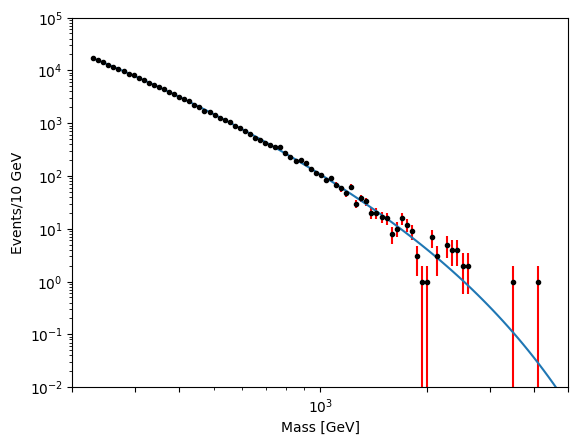

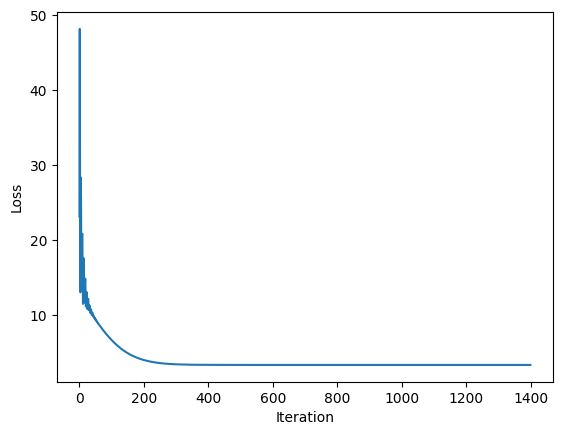

In [8]:
### Sped up version of class but now for fixd abp0

class optim_p4_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04, -0.001])

    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            N_iter_filter = 1400
            loss_crit = 1.5
            loss_filter = 3.35
            N_iter_filter = 1000
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:
            
            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            plt.errorbar(self.De_mass, self.De_event, yerr=self.yerr, fmt='.', color='black', ecolor='red')
            y_pred_4_plot = self.curve_torch_4(self.x_tensor, *theta_final).detach().numpy()
            plt.plot(self.De_mass, y_pred_4_plot)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 5000)
            plt.ylim(bottom = 10**-2, top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 5000])
            plt.show()

            f_loss,a_loss = plt.subplots()
            a_loss.plot(losses)
            # a_loss.set_yscale("log")
            a_loss.set_ylabel("Loss")
            a_loss.set_xlabel("Iteration")
            # a_loss.set_xlim(N_iter-1000, N_iter)
            # a_loss.set_ylim(0.55, 0.6)


# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

optimizer_class = optim_p4_poisson(data_path)
optimizer_class.run()

# for j in range(5):
#     losses_to_avg = []
#     for i in range (60):
#         optimizer_class = optim_p4_poisson(data_path)
#         optimizer_class.run()

#         losses_array = optimizer_class.losses
#         final_loss = losses_array[-1]
#         losses_to_avg.append(final_loss)
#     print(f"Average loss = {np.mean(losses_to_avg)}")

# Narrowing priors (regular optimise other values) /correct for new data and run/

Manually narrowed priors down to ranges:

a: 1.6 to 1.8 * 10**5 (Using fact that must be equal to number of events)

b: 1 to 5 (using Desmos and plotting loglike against p (with fixed a and p0, 180000 and -12, no other parameters)

p0: -10 to -15 (Desmos)

p1: -3.5 to -5.2 (Desmos)

p2: -0.45 to -1

p3: -0.1 to -0.045

p4: -0.001 to -0.006

Should also check if b 1 to 10 looks reasonable (for all other priors in same ranges, range of other priors shouldnt affect allowed values of b since b only finely adjusts and that too the tail)

Results of narrowing down using the code below shows that p0 can be cut down to at least -11 to -14, and potentially -11 to -13.5 (maybe even further, repeat many times and check)

Check what it suggests about b

After narrowing:

Should check what gradient values look like on same scatter plot at values close to low loglike points ie. within +/- 0.5 of loglike critical, plot in different colour

## b vs p0 (regular optimise other values)

In [ ]:
### Sped up version of class but now for fixed abp0

# Fix b and p0

class optim_p3_fix_bp0:
    def __init__(self, data_path, constant_b, constant_p0):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p0 = constant_p0

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, self.constant_p0, -5.2, -0.95, -0.1], high=[1.9 * 10**5, self.constant_b, self.constant_p0, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)
        # valid_indices = y_err_tensor > 0
        # chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        # return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i >= 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i >= 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 5
            loss_filter = 3.37
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 500 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    # print(f"Final loss before filter = {losses[-1]}")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta[i])
                if i >= 3:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

            # print(f"Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")

            # Plot results (ONLY NEED THIS FOR TORCH OPT i = 3 to plot result of each opt, not if opting for each b and p0 value)

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # a_loss.set_xlim(N_iter-1000, N_iter)
            # a_loss.set_ylim(0.55, 0.6)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_b_p0():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 10 # Real is 1 Viewing is 
    p0_ft_lower = -13.5 # Real is -15 Viewing is -20
    p0_ft_upper = -11 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p0_ft_values = torch.linspace(p0_ft_lower, p0_ft_upper, 6)
    B, P0 = torch.meshgrid(b_ft_values, p0_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p1_ft_values = torch.zeros(B.shape)
    p2_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(p0_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp0(data_path, b_ft_values[i], p0_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], b_ft_values[i], p0_ft_values[j], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p1_ft_values[i, j] = theta_final[3]
            p2_ft_values[i, j] = theta_final[4]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_bvsp0'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(p0_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[j].item())
                p1_values_array.append(p1_ft_values[i, j].item())
                p2_values_array.append(p2_ft_values[i, j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_bvsp0')

    # # Save file with gradients

    # def save_loglike_values(loglike_values, b_ft_values, p0_ft_values, loglike_b_gradients, loglike_p0_gradients, filename_prefix='loglike_history'):
    #     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    #     filename = f"{filename_prefix}_{timestamp}.csv"
        
    #     loglike_values = loglike_values.detach().numpy()

    #     b_values_array = []
    #     p0_values_array = []
    #     loglike_values_array = []
    #     loglike_b_gradients_array = []
    #     loglike_p0_gradients_array = []
    
    #     for i in range(len(b_ft_values)):
    #         for j in range((len(b_ft_values))):
    #             b_values_array.append(b_ft_values[i].item())
    #             p0_values_array.append(p0_ft_values[j].item())
    #             loglike_values_array.append(loglike_values[i, j].item())
    #             loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
    #             loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    #     b_values_array = np.array(b_values_array)
    #     p0_values_array = np.array(p0_values_array)
    #     loglike_values_array = np.array(loglike_values_array)
    #     loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    #     loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    #     # Create a DataFrame with appropriate headers
    #     df = pd.DataFrame({
    #         'b_values': b_values_array,
    #         'p0_values': p0_values_array,
    #         'loglikelihood': loglike_values_array,
    #         'loglike b grad': loglike_b_gradients_array,
    #         'loglike p0 grad': loglike_p0_gradients_array,
    #     })

    #     # Save the DataFrame to a new CSV file with headers
    #     df.to_csv(filename, index=False)
    #     print(f"Data saved to {filename}")

    # save_loglike_values(loglike_values, b_ft_values, p0_ft_values, loglike_b_gradients, loglike_p0_gradients, filename_prefix='loglike_history')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P0.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(p0_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[j].item())
            p1_values_array.append(p1_ft_values[i, j].item())
            p2_values_array.append(p2_ft_values[i, j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p0_values_array = np.array(p0_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = loglike_values_np.min() * 1.005

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
for i in range(5):
    contour_plot_b_p0()

## Replot b vs p0

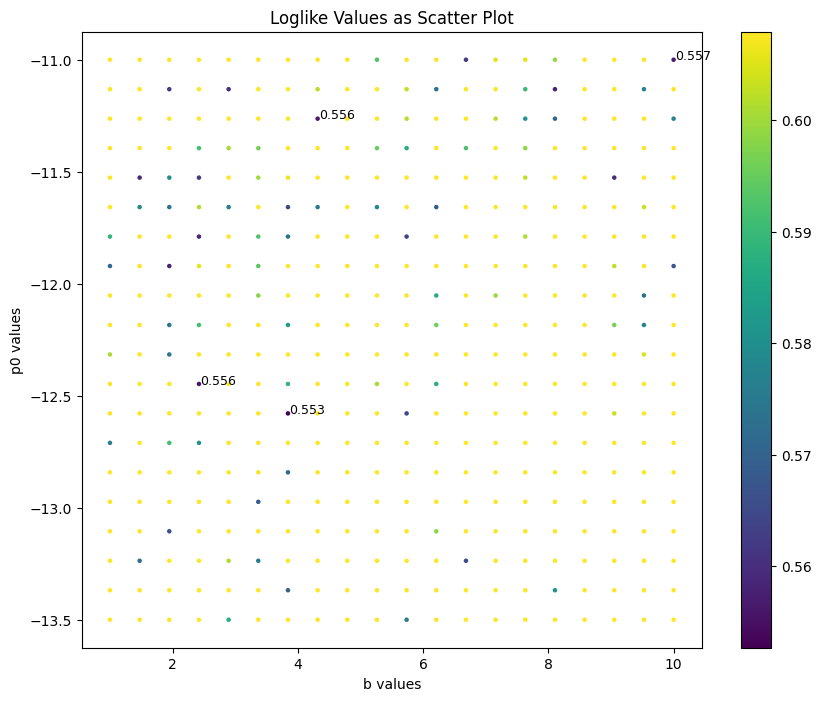

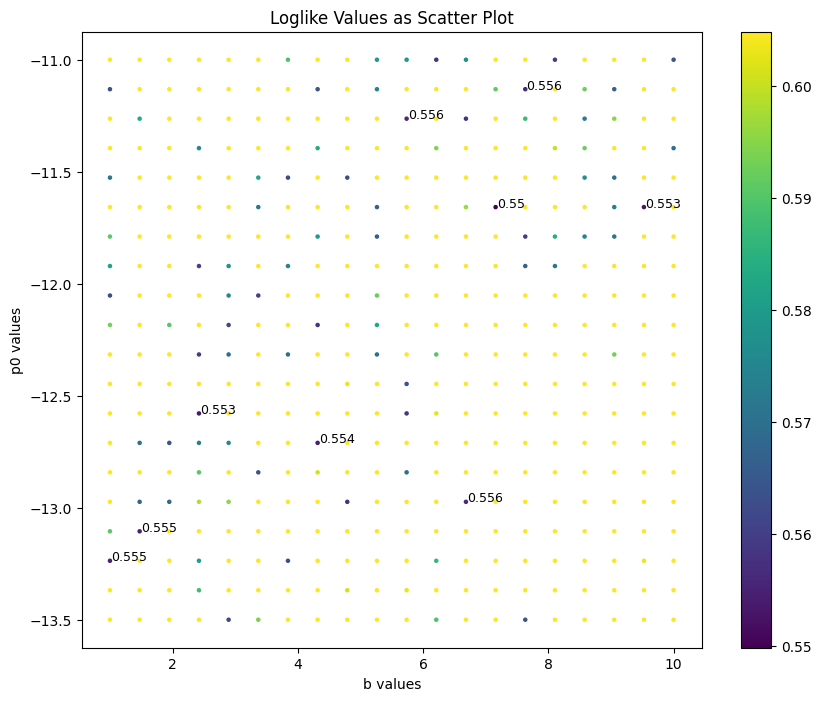

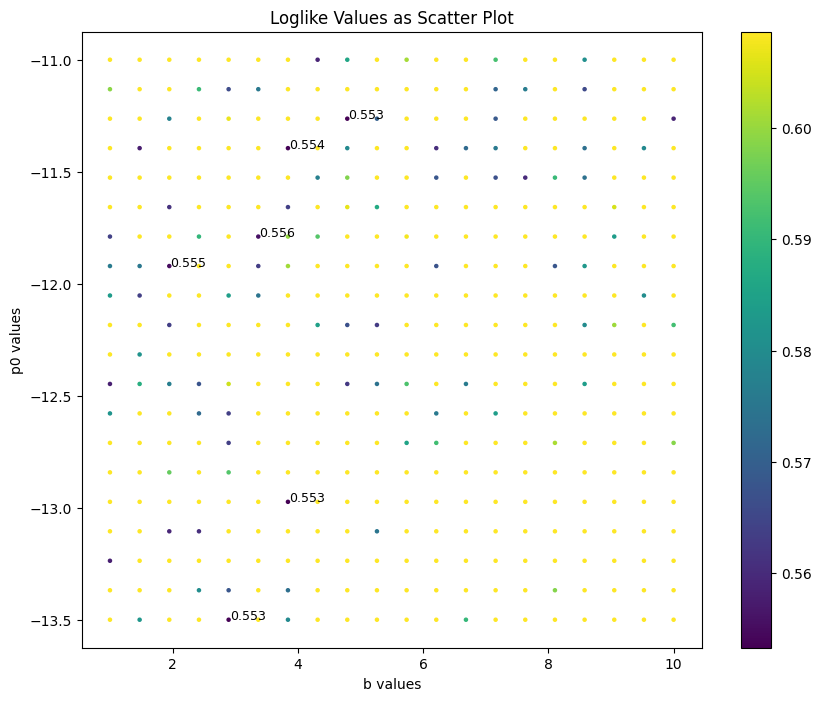

In [295]:
# Plotting results

def replot_scatter_b_p0(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.1)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.557

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_values_array[i], 3)), fontsize=9, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

# replot_scatter('loglike_history_20240307_063726_narrow_big_data.csv')
    
# replot_scatter('loglike_history_20240310_214317_all_params_2.csv')
    
# replot_scatter_b_p0('loglike_history_20240314_112350.csv') b 5 to 10

replot_scatter_b_p0('loglike_history_20240314_114139.csv') # b 1 to 10 repeat 1
replot_scatter_b_p0('loglike_history_20240314_114947.csv') # b 1 to 10 repeat 2
replot_scatter_b_p0('loglike_history_20240314_115737.csv') # b 1 to 10 repeat 3
    


# replot_scatter('loglike_history_20240306_194817_narrrow_w_new_ranges.csv')
# replot_scatter('loglike_history_20240306_200623_narrow_w_new_ranges_2.csv')
# replot_scatter('loglike_history_20240306_201303_narrow_w_new_ranges_3.csv')
# replot_scatter('loglike_history_20240306_204230_narrow_w_new_ranges_4.csv')
# replot_scatter('loglike_history_20240306_204924_narrow_w_new_ranges_5.csv')

## b vs p1 (regular optimise other values)

In [19]:
# Fix b and p1

class optim_p3_fix_bp1:
    def __init__(self, data_path, constant_b, constant_p1):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p1 = constant_p1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, -13.5, self.constant_p1, -0.95, -0.1], high=[1.9 * 10**5, self.constant_b, -11, self.constant_p1, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 4:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 5:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

            theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 4:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 5:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                pass
                # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 5
            loss_filter = 3
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 500 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    # print(f"Final loss before filter = {losses[-1]}")
                    break
            # else:
            #     print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta_opt[i-1])
                if i == 3:
                    theta_final.append(theta[i])
                if i == 4:
                    theta_final.append(theta_opt[i-2])
                if i == 5:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

            # print(f"Final loss = {losses[-1]}")

# Pairwise contour plots of loss (loglike() function)

def contour_plot_b_p1():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p1_ft_lower = -5.2 # Real is -15 Viewing is -20
    p1_ft_upper = -3.5 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p1_ft_values = torch.linspace(p1_ft_lower, p1_ft_upper, 6)
    B, P1 = torch.meshgrid(b_ft_values, p1_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p0_ft_values = torch.zeros(B.shape)
    p2_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(p1_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp1(data_path, b_ft_values[i], p1_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], theta_final[1], theta_final[2], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p0_ft_values[i, j] = theta_final[2]
            p2_ft_values[i, j] = theta_final[4]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p1'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(p1_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[i, j].item())
                p1_values_array.append(p1_ft_values[j].item())
                p2_values_array.append(p2_ft_values[i, j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p1')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P1.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(p1_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[i, j].item())
            p1_values_array.append(p1_ft_values[j].item())
            p2_values_array.append(p2_ft_values[i, j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p1_values_array = np.array(p1_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = loglike_values_np.min() * 1.005

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
    
for i in range(5):
    contour_plot_b_p1()

Initial Loss = 24.00551414489746
Final loss before filter = 3.706258773803711
Initial Loss = 22.21378517150879
Final loss before filter = 4.568360805511475
Initial Loss = 24.690032958984375
Final loss before filter = 3.695075035095215
Initial Loss = 21.050273895263672
Final loss before filter = 3.30654239654541
Initial Loss = 19.21385383605957
Final loss before filter = 3.821995973587036
Initial Loss = 23.943622589111328
Final loss before filter = 4.618109226226807
Initial Loss = 18.715944290161133
Final loss before filter = 5.609067916870117
Initial Loss = 17.680118560791016
Final loss before filter = 7.169319152832031
Initial Loss = 18.49734878540039
Final loss before filter = 3.2181947231292725
Initial Loss = 17.37824821472168
Final loss before filter = 3.2986936569213867
Initial Loss = 23.689340591430664
Final loss before filter = 3.9284985065460205
Initial Loss = 18.285154342651367
Final loss before filter = 3.470438003540039
Initial Loss = 24.937610626220703
Final loss before fil

KeyboardInterrupt: 

## Replot b vs p1

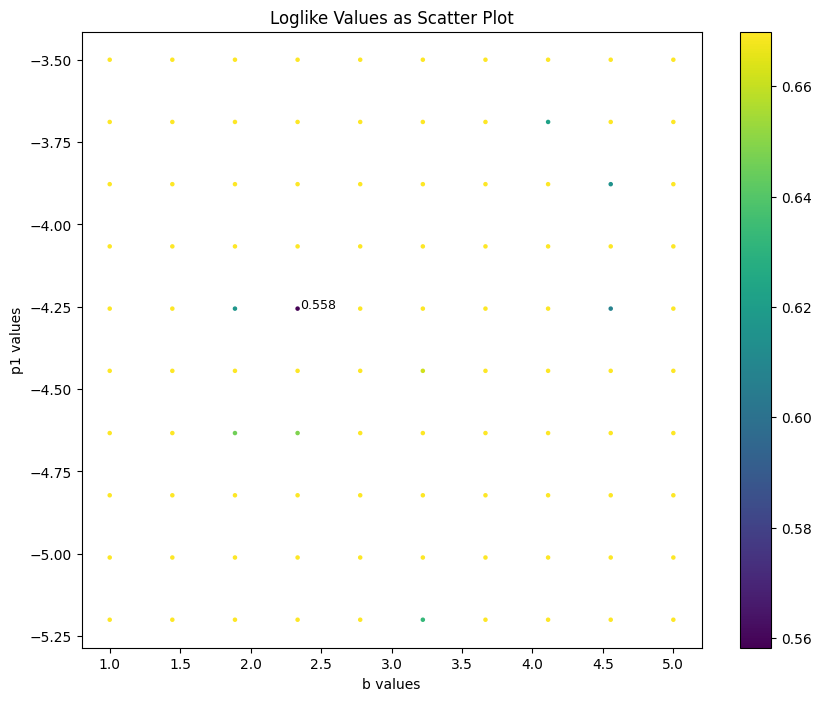

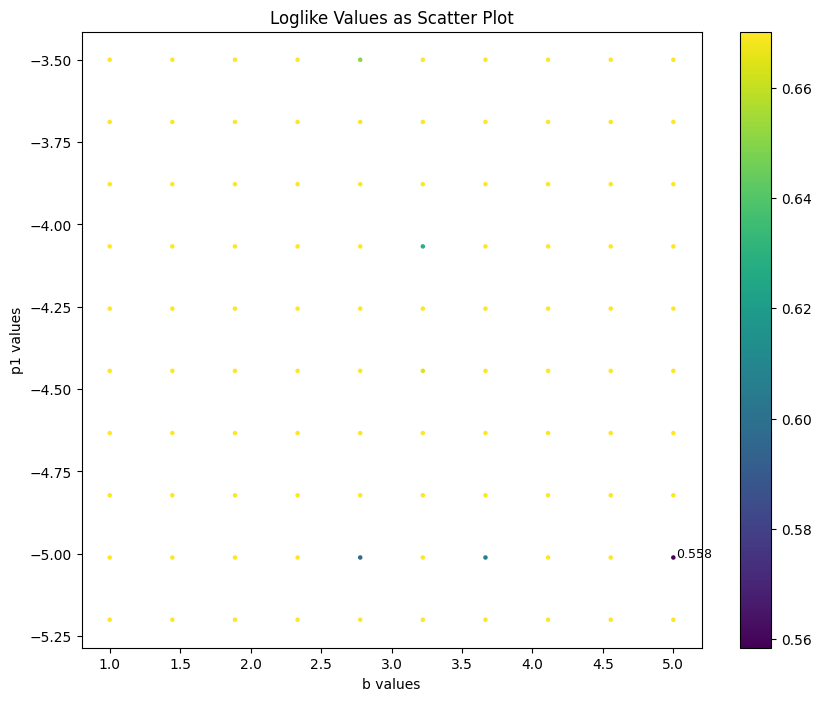

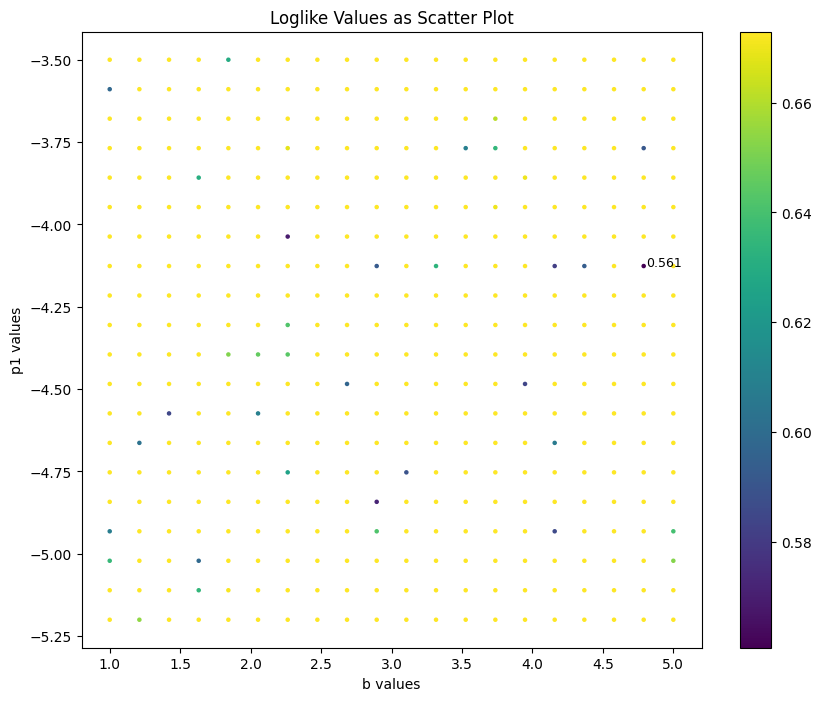

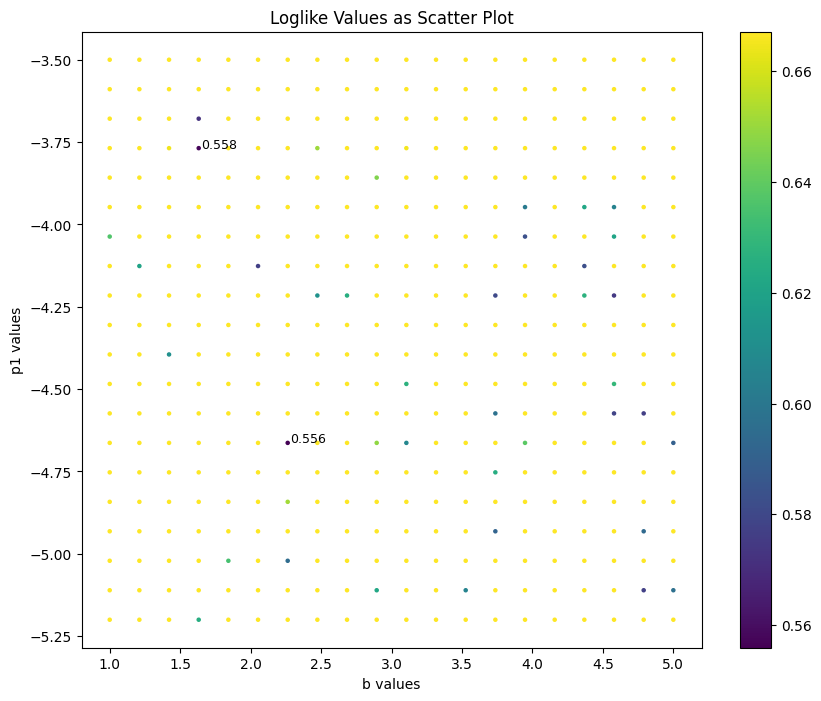

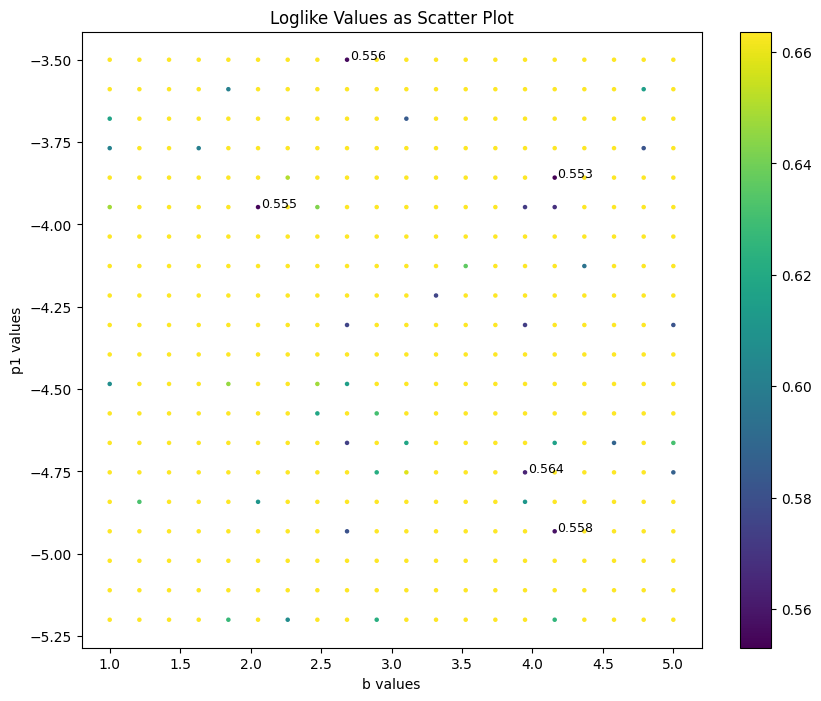

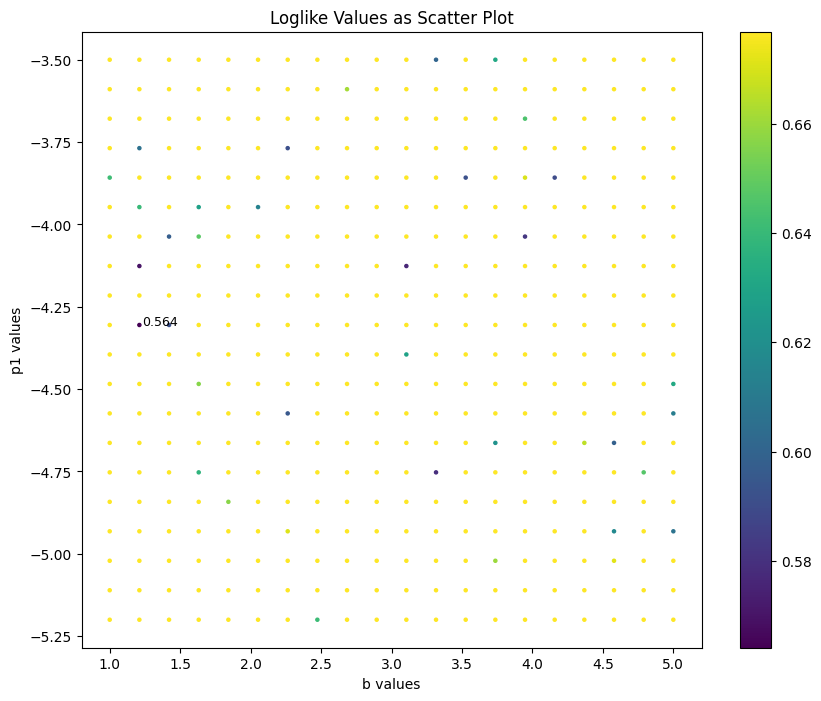

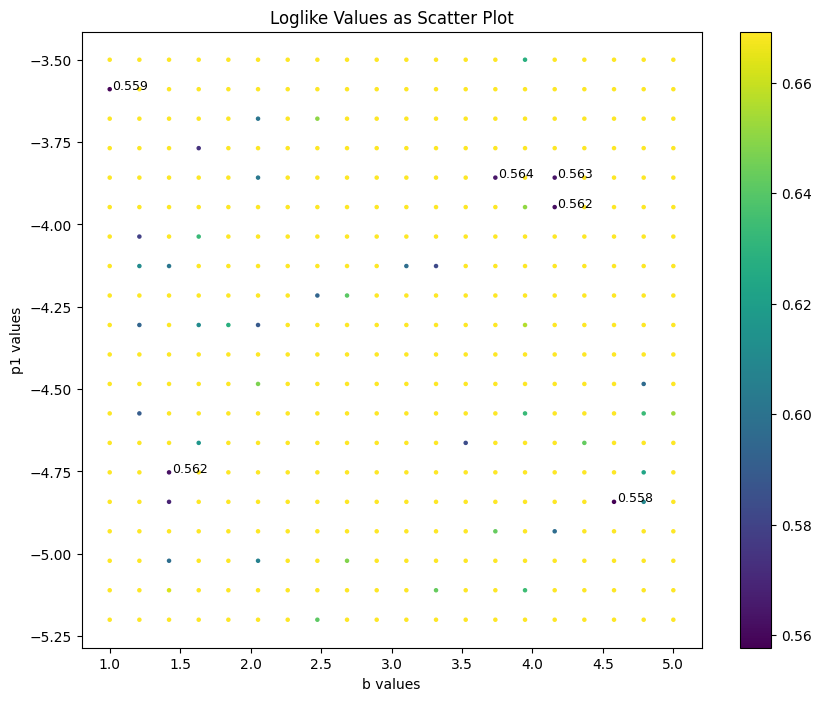

In [243]:
# Plotting results

def replot_scatter_b_p1(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p1 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.565

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i], str(round(loglike_values_array[i], 3)), fontsize=9, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

replot_scatter_b_p1('loglike_history_b_p1_20240312_212506_1.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_212601_2.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_213046_3.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_213406_4.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_213657_5.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_214003_6.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_214317_7.csv')

## Plot curves at critical loglike values

In [ ]:
def plot_curve_loglike_crit(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']
    # losses_array = data['losses']

    optimizer_class = optim_p3_poisson(data_path)

    x_tensor = optimizer_class.x_tensor
    curve_torch_3 = optimizer_class.curve_torch_3()

    critical_loglike_value = 0.56

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            print(f"""Critical loglike met, loglike = {loglike_val}\n 
                  a = {a_values_array[i]}\n 
                  b = {b_values_array[i]}\n
                  p0 = {p0_values_array[i]}\n
                  p1 = {p1_values_array[i]}\n
                  p2 = {p2_values_array[i]}\n
                  p3 = {p3_values_array[i]}""")
            
            plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            y_pred_3 = curve_torch_3(x_tensor, a_values_array[i], b_values_array[i], p0_values_array[i], p1_values_array[i], p2_values_array[i], p3_values_array[i]).detach().numpy()
            plt.plot(De_mass, y_pred_3)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 4000)
            plt.ylim(top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses_array)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

plot_curve_loglike_crit('loglike_history_20240310_212607_all_params.csv')

## Gradient (misc)

In [1]:
def calc_gradients(b, p0):
    # Placeholder for your model evaluation and log-likelihood calculation
    # You would replace this with calls to your model and log-likelihood functions
    # Ensure `b` and `p0` are PyTorch tensors with `requires_grad=True`
    optimizer_class = optim_p3_fix_abp0(data_path, b, p0)
    optimizer_class.run()
    theta_final = optimizer_class.theta_final
    y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], b, p0, theta_final[3], theta_final[4], theta_final[5])
    loglike_values[i, j] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
    log_likelihood = 
    
    # Calculate gradients
    log_likelihood.backward()
    
    # Access the gradients
    b_grad = b.grad.item()
    p0_grad = p0.grad.item()
    
    return b_grad, p0_grad

SyntaxError: invalid syntax (294395746.py, line 10)

# Narrowing priors (best each point method) /correct for new data and run/

Testing some code which will find the best loglike for each point, so will reduce stochastic effects of starting point etc. Does this by doing following process: choose starting point and optimise, if doesn't reach good loglikelihood within counter_lim then ups the critical loglieklihood and repeats, does this until critical loglikelihood is 0.6, if by then still hasn't reached this loglike then just end loop and plot. This means that can be more sure of loglike of each point since each point has been given a large nnumber of repeats to reach a critical logliekihood.

Modification: Maybe try same start point a few times before changing start point? Would it make much difference or will it optimise in same way? Surely will optimise same way becasue will take the same steps and apth since always steps in steepest gradient direction.

Need to check: Threshold requird to b high for some poionts but doesn't need to for others? Does it affect the other poiint which it doesn't need to be low for? Can I loop over threshold or maybe that would take too long?

## b vs p0

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[2, 0]
Calculated loglike_values[2, 1]
Calculated loglike_values[2, 2]
Calculated loglike_values[2, 3]
Calculated loglike_values[2, 4]
Calculated loglike_values[3, 0]
Calculated loglike_values[3, 1]
Calculated loglike_values[3, 2]
Calculated loglike_values[3, 3]
Calculated loglike_values[3, 4]
Calculated loglike_values[4, 0]
Calculated loglike_values[4, 1]
Calculated loglike_values[4, 2]
Calculated loglike_values[4, 3]
Calculated loglike_values[4, 4]
Calculated loglike_values[5, 0]
Calculated loglike_values[5, 1]
Calculated loglike_values[5, 2]
Calculated loglike_values[5, 3]
Calculated loglike_values[5, 4]
Calculated loglike_values[6, 0]
Calculat

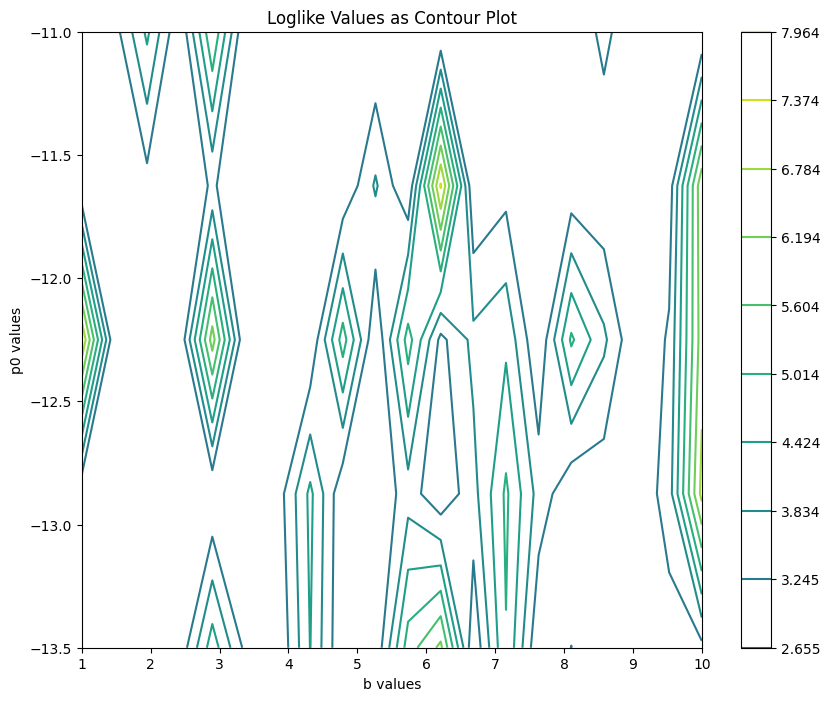

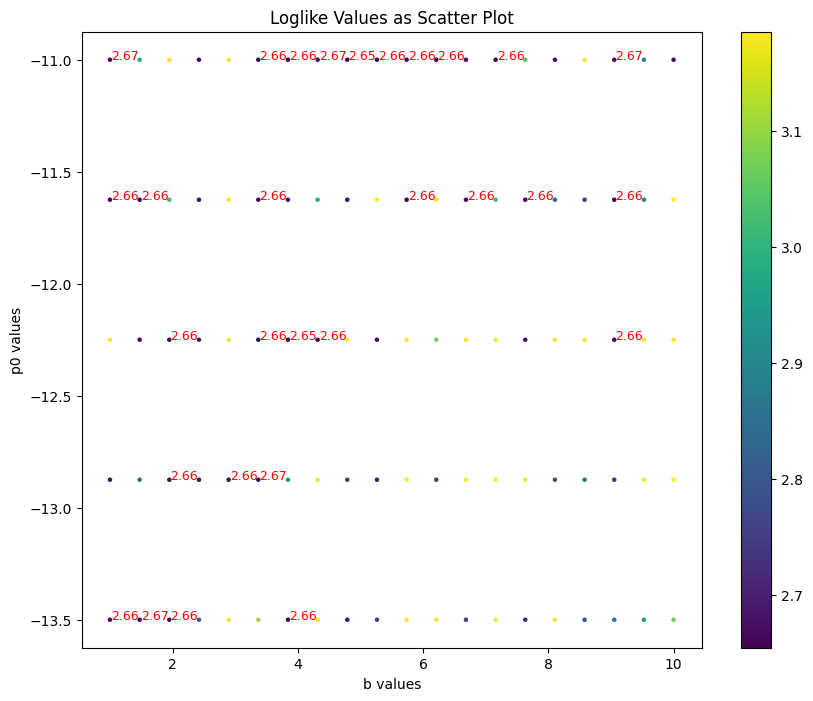

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[2, 0]
Calculated loglike_values[2, 1]
Calculated loglike_values[2, 2]
Calculated loglike_values[2, 3]
Calculated loglike_values[2, 4]
Calculated loglike_values[3, 0]
Calculated loglike_values[3, 1]
Calculated loglike_values[3, 2]
Calculated loglike_values[3, 3]
Calculated loglike_values[3, 4]
Calculated loglike_values[4, 0]
Calculated loglike_values[4, 1]
Calculated loglike_values[4, 2]
Calculated loglike_values[4, 3]
Calculated loglike_values[4, 4]
Calculated loglike_values[5, 0]
Calculated loglike_values[5, 1]
Calculated loglike_values[5, 2]
Calculated loglike_values[5, 3]
Calculated loglike_values[5, 4]
Calculated loglike_values[6, 0]
Calculat

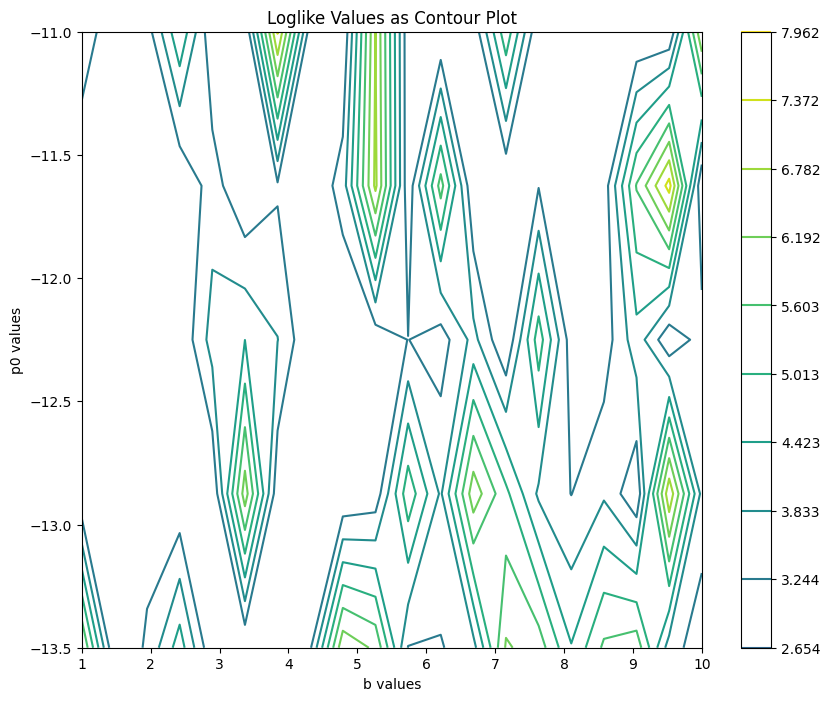

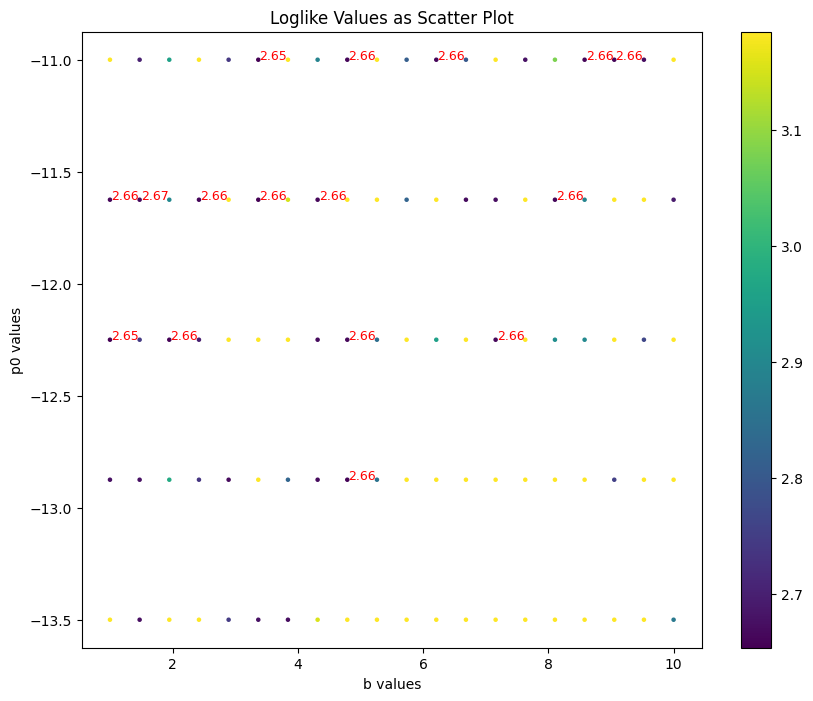

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[2, 0]
Calculated loglike_values[2, 1]
Calculated loglike_values[2, 2]
Calculated loglike_values[2, 3]
Calculated loglike_values[2, 4]
Calculated loglike_values[3, 0]
Calculated loglike_values[3, 1]
Calculated loglike_values[3, 2]
Calculated loglike_values[3, 3]
Calculated loglike_values[3, 4]
Calculated loglike_values[4, 0]
Calculated loglike_values[4, 1]
Calculated loglike_values[4, 2]
Calculated loglike_values[4, 3]
Calculated loglike_values[4, 4]
Calculated loglike_values[5, 0]
Calculated loglike_values[5, 1]
Calculated loglike_values[5, 2]
Calculated loglike_values[5, 3]
Calculated loglike_values[5, 4]
Calculated loglike_values[6, 0]
Calculat

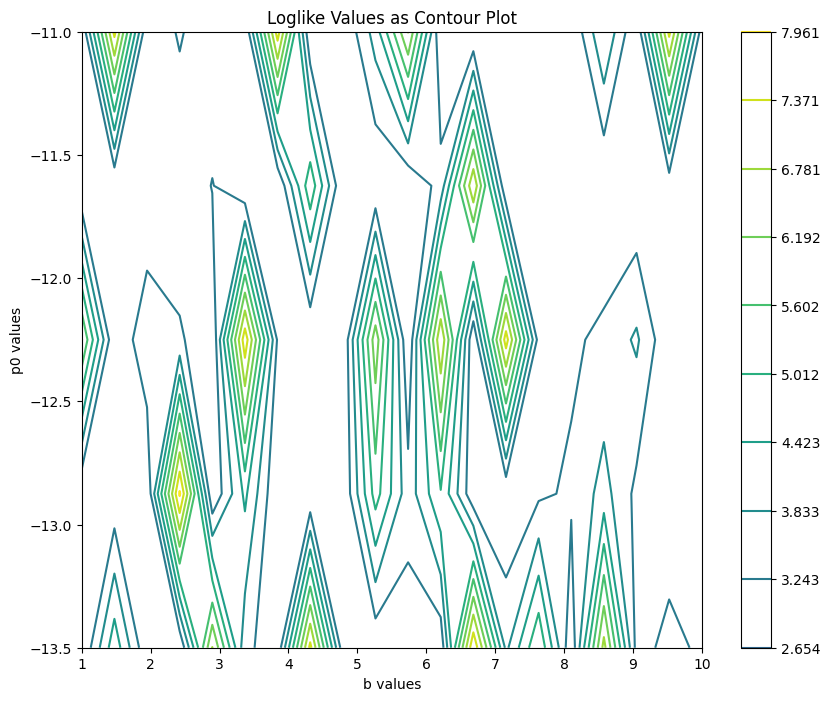

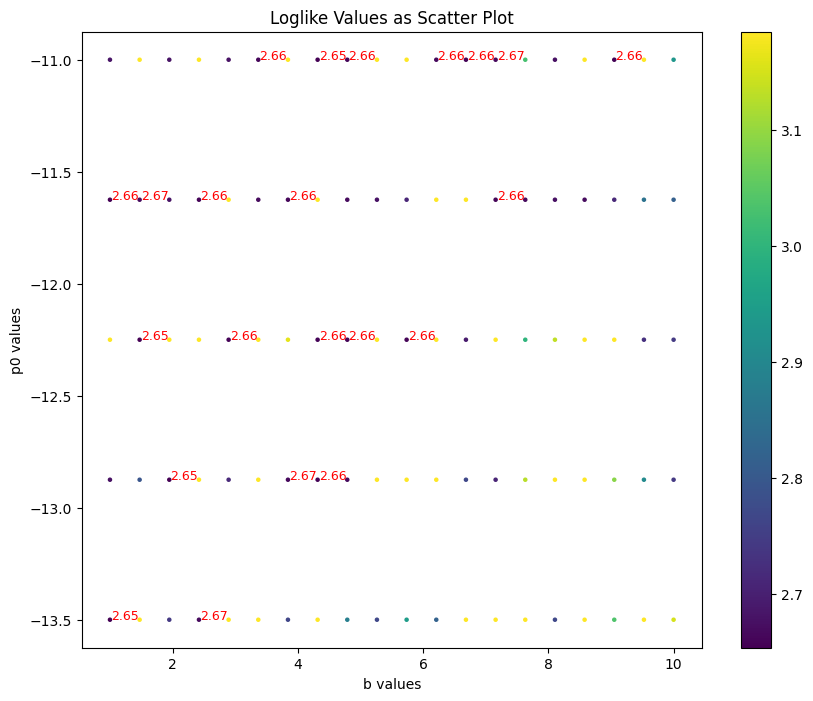

In [52]:
class optim_p3_fix_bp0_best_each_point:
    def __init__(self, data_path, constant_b, constant_p0):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p0 = constant_p0

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, self.constant_p0, -5.2, -0.95, -0.1], high=[1.9 * 10**5, self.constant_b, self.constant_p0, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self):
        priors = self.create_priors()
        theta = []
        theta_opt = []
        for i in range(len(priors)):
            if i == 0:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 1:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 2:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 3:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 4:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 5:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

        theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

        if self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) >= self.threshold():
            while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
                priors = self.create_priors()
                theta = []
                theta_opt = []
                for i in range(len(priors)):
                    if i == 0:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 1:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 2:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 3:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 4:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 5:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

                theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:

            counter = 0
            counter_lim = 5
            max_N = 1000
            loss_crit = 5
            loss_filter = 0.6
            loss_accept = 2.65
            final_loss_accept = 2.68
            losses_graphs = []
            final_losses = []

            while loss_accept < final_loss_accept:
                while counter <= counter_lim:

                    initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3()
                    optimizer = Adam([theta_opt], lr=0.001)
                    loss = initial_loss
                    losses = []
                    N_iter = 0

                    while N_iter < max_N:
                        # if N_iter == 0:
                        #     print(f"Initial Loss = {loss}")
                        optimizer.zero_grad()
                        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
                        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                        loss.backward()
                        optimizer.step()
                        losses.append(loss.detach().numpy())
                        N_iter += 1
                        if N_iter == max_N and loss > loss_accept:
                            # print(f"Final Loss too high. Adding 1 to counter.")
                            # print(f"Final Loss = {losses[-1]}, too high. Adding 1 to counter.")
                            final_losses.append(loss.detach().numpy())
                            losses_graphs.append(losses)
                            counter += 1
                            break
                        if N_iter == max_N and loss <= loss_accept:
                            counter = counter_lim + 1
                            break
                    if loss <= loss_accept:
                        break
                    if counter == counter_lim and loss > loss_accept:
                        # print("Counter limit reached. Adding 0.01 to loss_accept and resetting counter.")
                        loss_accept += 0.01
                        # print(f"Loss_accept = {loss_accept}, Final_loss_accept = {final_loss_accept}")
                        counter = 0
                        # if loss_accept >= final_loss_accept:
                            # print(f"Loss accept has reached limit.")
                        break
                if loss <= loss_accept:
                    break
                if loss_accept >= final_loss_accept:
                    break
            if loss <= loss_accept:
                success = True
                break
            if loss_accept >= final_loss_accept: #Once total count has been reached, change success to true regardless of loglike value obtained
                final_losses = np.array(final_losses)
                losses_graphs = np.array(losses_graphs)
                loss = final_losses.min()
                index = final_losses.argmin()
                losses = losses_graphs[index]
                success = True
                break

        # if loss < loss_accept: # If escaped total count and counter loops and loss < loss accept then success achieved
        #     print(f"Success achieved, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        # if loss >= loss_accept: # If escaped total count and counter loops only after limit then must mean loss >= loss accept so no success achieved
        #     print(f"Limit reached, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        if success == True:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta[i])
                if i == 3:
                    theta_final.append(theta_opt[i-2])
                if i == 4:
                    theta_final.append(theta_opt[i-2])
                if i == 5:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_bp0_best_each_point():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 10 # Real is 1 Viewing is 
    p0_ft_lower = -13.5 # Real is -15 Viewing is -20
    p0_ft_upper = -11 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p0_ft_values = torch.linspace(p0_ft_lower, p0_ft_upper, 5)
    B, P0 = torch.meshgrid(b_ft_values, p0_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p1_ft_values = torch.zeros(B.shape)
    p2_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(p0_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp0_best_each_point(data_path, b_ft_values[i], p0_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], theta_final[1], theta_final[2], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p1_ft_values[i, j] = theta_final[3]
            p2_ft_values[i, j] = theta_final[4]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p0_best_each_point'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(p0_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[j].item())
                p1_values_array.append(p1_ft_values[i, j].item())
                p2_values_array.append(p2_ft_values[i, j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p0_best_each_point')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P0.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(p0_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[j].item())
            p1_values_array.append(p1_ft_values[i, j].item())
            p2_values_array.append(p2_ft_values[i, j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p0_values_array = np.array(p0_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = loglike_values_np.min() * 1.005

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
    
for i in range(3):
    contour_plot_bp0_best_each_point()

## Replot b vs p0

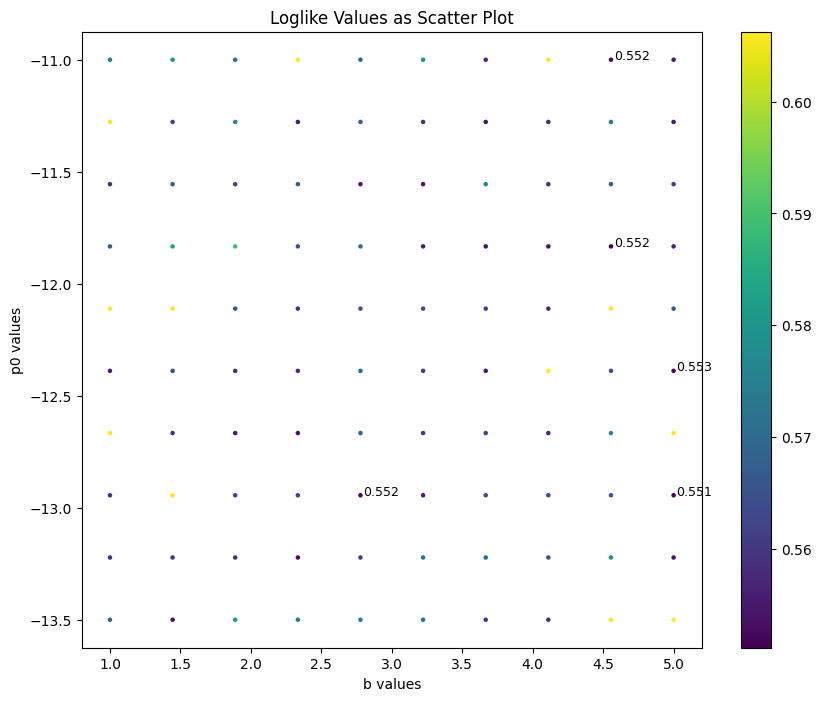

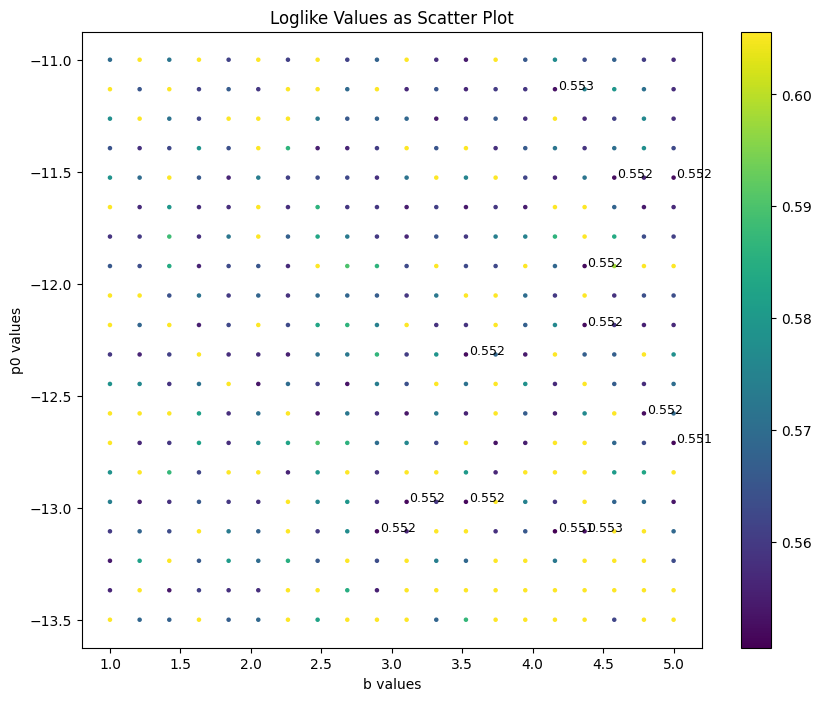

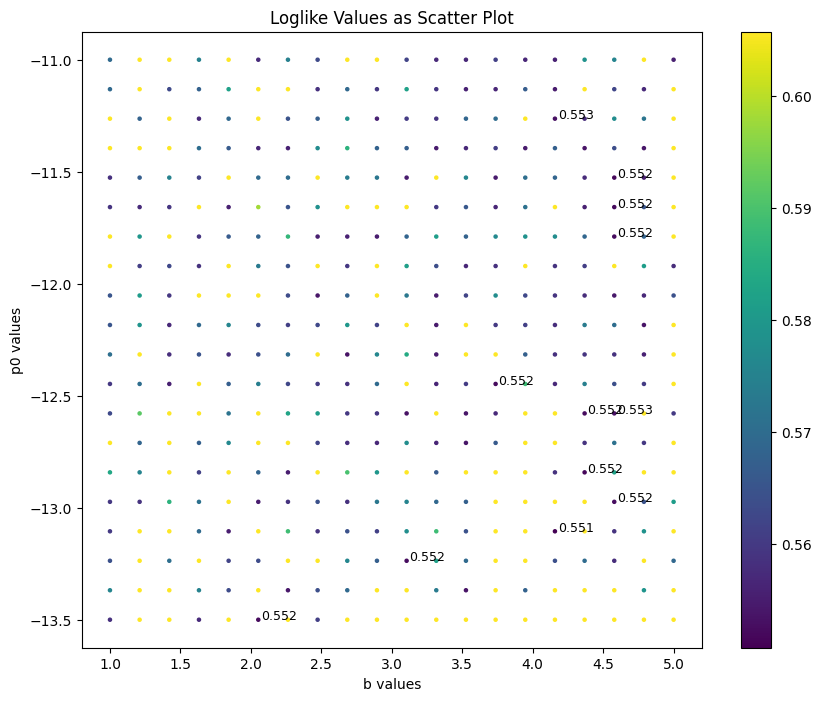

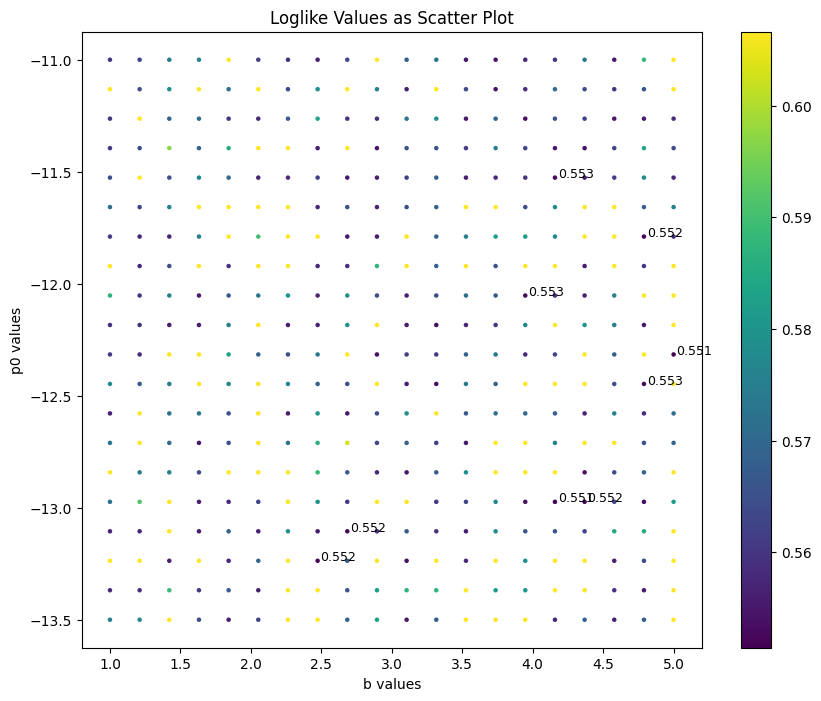

In [ ]:
# Plotting results

def replot_scatter_b_p0(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.1)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.553

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_values_array[i], 3)), fontsize=9, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

replot_scatter_b_p0("loglike_history_b_p0_best_each_point_20240313_235235.csv")
replot_scatter_b_p0("loglike_history_b_p0_best_each_point_20240314_014006.csv")
replot_scatter_b_p0("loglike_history_b_p0_best_each_point_20240314_030139.csv")
replot_scatter_b_p0("loglike_history_b_p0_best_each_point_20240314_042215.csv")

## b vs p1

In [ ]:
class optim_p3_fix_bp1_best_each_point:
    def __init__(self, data_path, constant_b, constant_p1):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p1 = constant_p1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, -13.5, self.constant_p1, -0.95, -0.1], high=[1.9 * 10**5, self.constant_b, -11, self.constant_p1, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 100

    def adjust_theta_3(self):
        priors = self.create_priors()
        theta = []
        theta_opt = []
        for i in range(len(priors)):
            if i == 0:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 1:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 2:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 3:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 4:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 5:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

        theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

        if self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) >= self.threshold():
            while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
                priors = self.create_priors()
                theta = []
                theta_opt = []
                for i in range(len(priors)):
                    if i == 0:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 1:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 2:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 3:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 4:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 5:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

                theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:

            counter = 0
            counter_lim = 20
            max_N = 1000
            loss_crit = 5
            loss_filter = 0.6
            loss_accept = 0.55
            final_loss_accept = 0.60

            while loss_accept < final_loss_accept:
                while counter <= counter_lim:

                    initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3()
                    optimizer = Adam([theta_opt], lr=0.001)
                    loss = initial_loss
                    losses = []
                    N_iter = 0

                    while N_iter < max_N:
                        # if N_iter == 0:
                        #     print(f"Initial Loss = {loss}")
                        optimizer.zero_grad()
                        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
                        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                        loss.backward()
                        optimizer.step()
                        losses.append(loss.detach().numpy())
                        N_iter += 1
                        if N_iter == max_N and loss > loss_accept:
                            # print(f"Final Loss too high. Adding 1 to counter.")
                            # print(f"Final Loss = {losses[-1]}, too high. Adding 1 to counter.")
                            counter += 1
                            break
                        if N_iter == max_N and loss <= loss_accept:
                            counter = counter_lim + 1
                            break
                    if loss <= loss_accept:
                        break
                    if counter == counter_lim and loss >= loss_accept:
                        # print("Counter limit reached. Adding 0.01 to loss_accept and resetting counter.")
                        loss_accept += 0.01
                        # print(f"Loss_accept = {loss_accept}, Final_loss_accept = {final_loss_accept}")
                        counter = 0
                        # if loss_accept >= final_loss_accept:
                            # print(f"Loss accept has reached limit.")
                        break
                if loss <= loss_accept:
                    break
                if loss_accept >= final_loss_accept:
                    break
            if loss <= loss_accept:
                success = True
                break
            if loss_accept >= final_loss_accept: #Once total count has been reached, change success to true regardless of loglike value obtained
                success = True
                break

        # if loss < loss_accept: # If escaped total count and counter loops and loss < loss accept then success achieved
        #     print(f"Success achieved, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        # if loss >= loss_accept: # If escaped total count and counter loops only after limit then must mean loss >= loss accept so no success achieved
        #     print(f"Limit reached, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        if success == True:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta_opt[i-1])
                if i == 3:
                    theta_final.append(theta[i])
                if i == 4:
                    theta_final.append(theta_opt[i-2])
                if i == 5:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_bp1_best_each_point():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p1_ft_lower = -5.2 # Real is -15 Viewing is -20
    p1_ft_upper = -3.5 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p1_ft_values = torch.linspace(p1_ft_lower, p1_ft_upper, 6)
    B, P1 = torch.meshgrid(b_ft_values, p1_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p0_ft_values = torch.zeros(B.shape)
    p2_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(p1_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp1_best_each_point(data_path, b_ft_values[i], p1_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], theta_final[1], theta_final[2], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p0_ft_values[i, j] = theta_final[2]
            p2_ft_values[i, j] = theta_final[4]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p1_best_each_point'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(p1_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[i, j].item())
                p1_values_array.append(p1_ft_values[j].item())
                p2_values_array.append(p2_ft_values[i, j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p1_best_each_point')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P1.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p1 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(p1_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[i, j].item())
            p1_values_array.append(p1_ft_values[j].item())
            p2_values_array.append(p2_ft_values[i, j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p1_values_array = np.array(p1_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p1 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = loglike_values_np.min() * 1.005

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
    
for i in range(3):
    contour_plot_bp1_best_each_point()

## Replot b vs p1

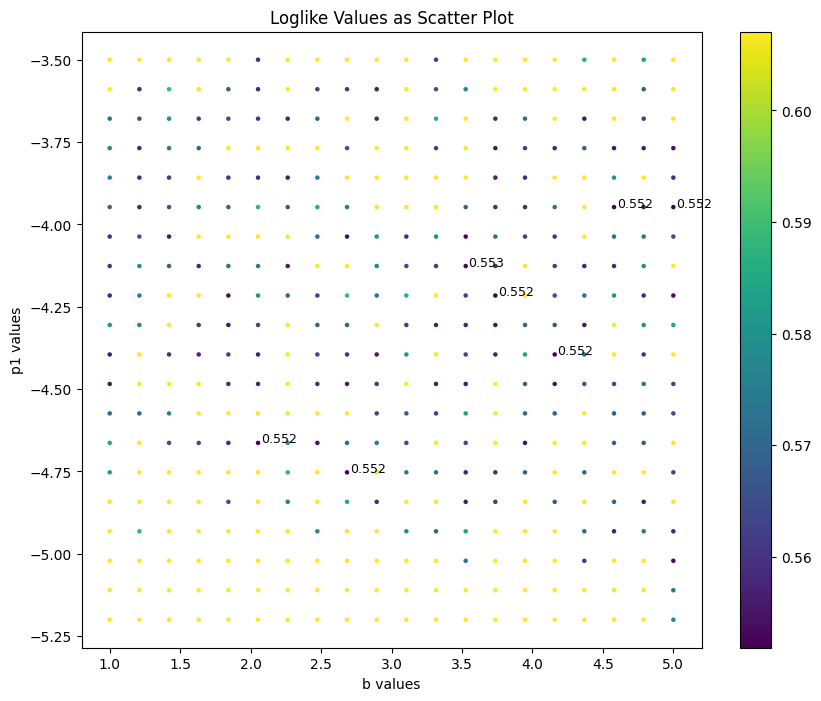

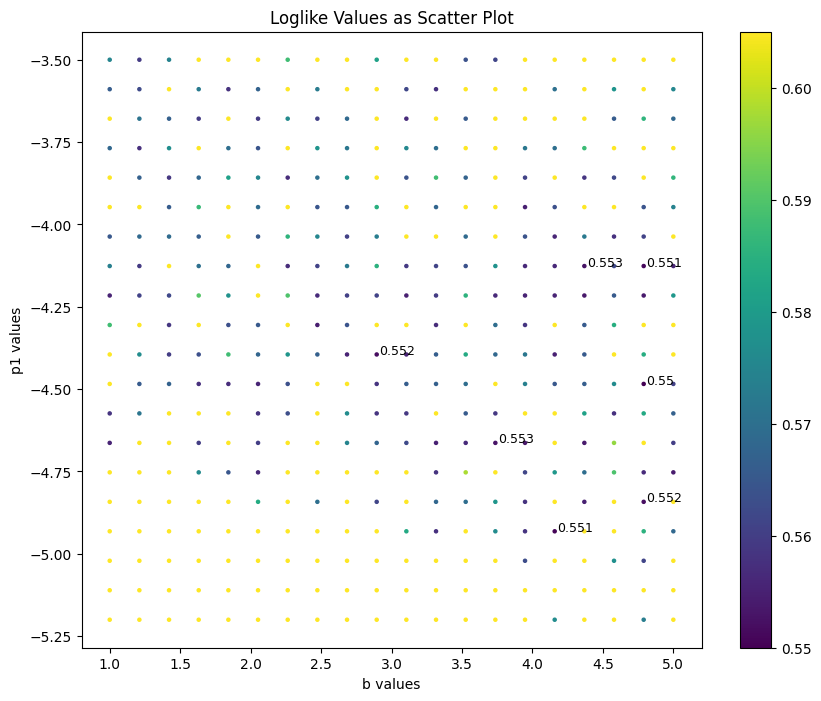

In [ ]:
# Plotting results

def replot_scatter_b_p1(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.1)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p1 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.553

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i], str(round(loglike_values_array[i], 3)), fontsize=9, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

replot_scatter_b_p1("loglike_history_b_p1_best_each_point_20240314_072059.csv")
replot_scatter_b_p1("loglike_history_b_p1_best_each_point_20240314_103842.csv")

## b vs p2

In [ ]:
class optim_p3_fix_bp2_best_each_point:
    def __init__(self, data_path, constant_b, constant_p2):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p2 = constant_p2

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, -13.5, -5.2, self.constant_p2, -0.1], high=[1.9 * 10**5, self.constant_b, -11, -3.5, self.constant_p2, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 100

    def adjust_theta_3(self):
        priors = self.create_priors()
        theta = []
        theta_opt = []
        for i in range(len(priors)):
            if i == 0:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 1:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 2:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 3:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 4:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 5:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

        theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta_opt[2], theta[4], theta_opt[3])
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

        if self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) >= self.threshold():
            while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
                priors = self.create_priors()
                theta = []
                theta_opt = []
                for i in range(len(priors)):
                    if i == 0:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 1:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 2:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 3:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 4:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 5:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

                theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta_opt[2], theta[4], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:

            counter = 0
            counter_lim = 20
            max_N = 1000
            loss_crit = 5
            loss_filter = 0.6
            loss_accept = 0.55
            final_loss_accept = 0.60

            while loss_accept < final_loss_accept:
                while counter <= counter_lim:

                    initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3()
                    optimizer = Adam([theta_opt], lr=0.001)
                    loss = initial_loss
                    losses = []
                    N_iter = 0

                    while N_iter < max_N:
                        # if N_iter == 0:
                        #     print(f"Initial Loss = {loss}")
                        optimizer.zero_grad()
                        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta_opt[2], theta[4], theta_opt[3])
                        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                        loss.backward()
                        optimizer.step()
                        losses.append(loss.detach().numpy())
                        N_iter += 1
                        if N_iter == max_N and loss > loss_accept:
                            # print(f"Final Loss too high. Adding 1 to counter.")
                            # print(f"Final Loss = {losses[-1]}, too high. Adding 1 to counter.")
                            counter += 1
                            break
                        if N_iter == max_N and loss <= loss_accept:
                            counter = counter_lim + 1
                            break
                    if loss <= loss_accept:
                        break
                    if counter == counter_lim and loss >= loss_accept:
                        # print("Counter limit reached. Adding 0.01 to loss_accept and resetting counter.")
                        loss_accept += 0.01
                        # print(f"Loss_accept = {loss_accept}, Final_loss_accept = {final_loss_accept}")
                        counter = 0
                        # if loss_accept >= final_loss_accept:
                            # print(f"Loss accept has reached limit.")
                        break
                if loss <= loss_accept:
                    break
                if loss_accept >= final_loss_accept:
                    break
            if loss <= loss_accept:
                success = True
                break
            if loss_accept >= final_loss_accept: #Once total count has been reached, change success to true regardless of loglike value obtained
                success = True
                break

        # if loss < loss_accept: # If escaped total count and counter loops and loss < loss accept then success achieved
        #     print(f"Success achieved, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        # if loss >= loss_accept: # If escaped total count and counter loops only after limit then must mean loss >= loss accept so no success achieved
        #     print(f"Limit reached, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        if success == True:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta_opt[i-1])
                if i == 3:
                    theta_final.append(theta_opt[i-1])
                if i == 4:
                    theta_final.append(theta[i])
                if i == 5:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_bp2_best_each_point():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p2_ft_lower = -0.95 # Real is -15 Viewing is -20
    p2_ft_upper = -0.45 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p2_ft_values = torch.linspace(p2_ft_lower, p2_ft_upper, 20)
    B, P2 = torch.meshgrid(b_ft_values, p2_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p0_ft_values = torch.zeros(B.shape)
    p1_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(p2_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp2_best_each_point(data_path, b_ft_values[i], p2_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], theta_final[1], theta_final[2], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p0_ft_values[i, j] = theta_final[2]
            p1_ft_values[i, j] = theta_final[3]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p2_best_each_point'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(p2_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[i, j].item())
                p1_values_array.append(p1_ft_values[i, j].item())
                p2_values_array.append(p2_ft_values[j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p2_best_each_point')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P2.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p2 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(p2_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[i, j].item())
            p1_values_array.append(p1_ft_values[i, j].item())
            p2_values_array.append(p2_ft_values[j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p2_values_array = np.array(p2_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p2_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p2 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.57

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p2_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
    
for i in range(3):
    contour_plot_bp2_best_each_point()

# Generate data and calculate Bayes factor

In [ ]:
# Generate datasets
            
log_K_array = []

for j in range(500):

    # Usage
    N = 10**3
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p4_poisson(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_4 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_4_rvs_priors = optimizer_class.curve_torch_4(x_tensor, *theta)
        y_pred_4_rvs_priors_plus_noise = torch.poisson(y_pred_4_rvs_priors)
        array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_3)
    D4 = np.array(array_vector_datasets_4)

    X = x_me

    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            # kwargs['batch_size'] = 128
            kwargs['num_epochs'] = 30
            super().fit(X, y, **kwargs)

    evidence_network = CustomBinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D4))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    for k in range(1):
        # log_K_sub_array = []
        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        # log_K_sub_array.append(log_K)
        print(f"Bayes Factor = {log_K}")

    log_K_array.append(log_K)

plt.hist(log_K_array, bins=50, edgecolor='black')
plt.title('Histogram of log_k')
plt.xlabel('log_k')
plt.ylabel('Frequency')
plt.show()
    

Norm = 0.0017248523654416203
Base function = tensor([0.9364, 0.9344, 0.9322, 0.9300, 0.9277, 0.9254, 0.9230, 0.9205, 0.9179,
        0.9153, 0.9125, 0.9097, 0.9068, 0.9038, 0.9007, 0.8975, 0.8942, 0.8909,
        0.8874, 0.8838, 0.8801, 0.8763, 0.8723, 0.8683, 0.8641, 0.8598, 0.8554,
        0.8509, 0.8462, 0.8414, 0.8364, 0.8313, 0.8261, 0.8207, 0.8152, 0.8095,
        0.8036, 0.7976, 0.7914, 0.7850, 0.7785, 0.7718, 0.7649, 0.7578, 0.7505,
        0.7431, 0.7355, 0.7276, 0.7196, 0.7114, 0.7029, 0.6943, 0.6854, 0.6764,
        0.6671, 0.6576, 0.6480, 0.6381, 0.6279, 0.6176, 0.6071, 0.5963, 0.5853,
        0.5742, 0.5628, 0.5512, 0.5394, 0.5274, 0.5152, 0.5028, 0.4902, 0.4775,
        0.4646, 0.4515, 0.4383, 0.4249, 0.4114, 0.3978, 0.3841, 0.3703, 0.3564,
        0.3424, 0.3284, 0.3144, 0.3004, 0.2864, 0.2724, 0.2585, 0.2447, 0.2310,
        0.2174, 0.2041, 0.1909, 0.1779, 0.1652, 0.1527, 0.1406, 0.1289, 0.1175])
X function = tensor([1.6400e+11, 1.4853e+11, 1.3416e+11, 1.2089e+11, 1.086

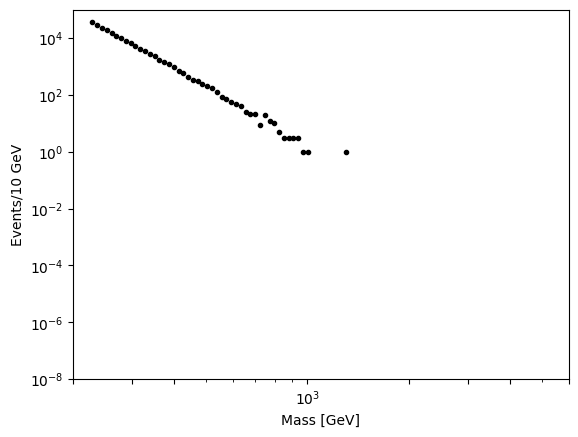

theta_4 = [ 1.77081819e+05  3.01156575e+00 -1.19434867e+01 -3.78055325e+00
 -8.48338271e-01 -8.89468419e-02 -4.18025017e-03]
[4.0892e+04 3.1180e+04 2.4017e+04 1.8275e+04 1.3938e+04 1.0827e+04
 8.2680e+03 6.3720e+03 4.9550e+03 3.8540e+03 3.0320e+03 2.2840e+03
 1.8580e+03 1.5000e+03 1.0670e+03 8.8400e+02 7.2000e+02 5.5200e+02
 4.3900e+02 3.5000e+02 2.8700e+02 2.0500e+02 1.6400e+02 1.3200e+02
 9.9000e+01 7.1000e+01 7.1000e+01 4.6000e+01 4.0000e+01 3.8000e+01
 2.5000e+01 2.2000e+01 1.6000e+01 8.0000e+00 1.0000e+01 9.0000e+00
 4.0000e+00 5.0000e+00 6.0000e+00 4.0000e+00 4.0000e+00 5.0000e+00
 1.0000e+00 2.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0

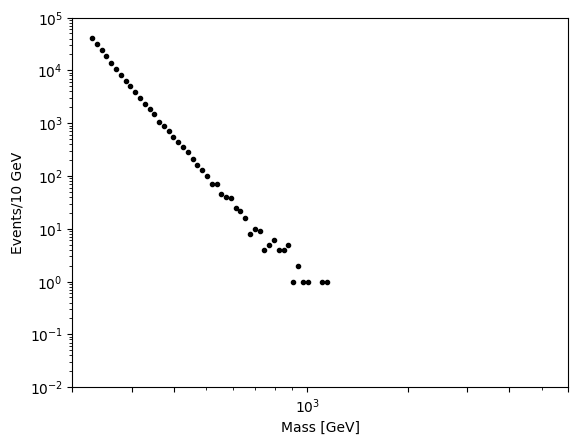

In [162]:
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
optimizer_class_3 = optim_p3_poisson(data_path)
x_tensor = optimizer_class_3.x_tensor
array_vector_datasets_3 = []
theta_3 = optimizer_class_3.create_priors()
y_pred_3_rvs_priors = optimizer_class_3.curve_torch_3(x_tensor, *theta_3)
y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())


print(f"theta_3 = {theta_3}")
print(f"Before noise = {y_pred_3_rvs_priors}")
print(f"After noise  = {array_vector_datasets_3[0]}")
print(f"Masses = {optimizer_class_3.De_mass}")
for i,elem in enumerate(array_vector_datasets_3[0]):
    if elem == 0:
        print(f"Negative value at De_mass = {optimizer_class.De_mass[i]}")
plt.errorbar(optimizer_class.De_mass, array_vector_datasets_3[0], fmt='.', color='black', ecolor='red')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Mass [GeV]")
plt.ylabel("Events/10 GeV")
plt.xlim(200, 6000)
plt.ylim(bottom = 10**-8, top=10**5)
plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 6000])
plt.show()

optimizer_class_4 = optim_p4_poisson(data_path)
x_tensor = optimizer_class_4.x_tensor
array_vector_datasets_4 = []
theta_4 = optimizer_class_4.create_priors()
y_pred_4_rvs_priors = optimizer_class_4.curve_torch_4(x_tensor, *theta_4)
y_pred_4_rvs_priors_plus_noise = torch.poisson(y_pred_4_rvs_priors)
array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

print(f"theta_4 = {theta_4}")
print(array_vector_datasets_4[0])
plt.errorbar(optimizer_class.De_mass, array_vector_datasets_4[0], fmt='.', color='black', ecolor='red')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Mass [GeV]")
plt.ylabel("Events/10 GeV")
plt.xlim(200, 6000)
plt.ylim(bottom = 10**-2, top=10**5)
plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 6000])
plt.show()

# Generate data and caluclating Bayes factor TESTING GROUND

In [12]:
# Generate datasets
            
log_K_array = []
log_K_array_means = []
log_K_array_sub_array_means = []
num_sim_dataset_arrays_train_on = 1
num_sim_datasets_per_array = 10**3
num_val_datasets = 100
num_train_rounds = 500

for i in range(num_sim_dataset_arrays_train_on):

    # Usage
    N = num_sim_datasets_per_array
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    while len(array_vector_datasets_3) < N:
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        if all(y_val > 1 for y_val in y_pred_3_rvs_priors_plus_noise[:80]) and all(y_val > 10**2 for y_val in y_pred_3_rvs_priors_plus_noise[:1]):
            array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p4_poisson(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_4 = []
    while len(array_vector_datasets_4) < N:
        theta = optimizer_class.create_priors()
        y_pred_4_rvs_priors = optimizer_class.curve_torch_4(x_tensor, *theta)
        y_pred_4_rvs_priors_plus_noise = torch.poisson(y_pred_4_rvs_priors)
        if all(y_val > 1 for y_val in y_pred_4_rvs_priors_plus_noise[:80]) and all(y_val > 10**2 for y_val in y_pred_4_rvs_priors_plus_noise[:1]):
            array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Simulating validation datasets from i = 4

    array_vector_datasets_4_validation = []
    theta_validation = []

    while len(array_vector_datasets_4_validation) < num_val_datasets:
        optimizer_class = optim_p4_poisson(data_path)
        x_tensor = optimizer_class.x_tensor
        theta = optimizer_class.create_priors()
        y_pred_4_rvs_priors_validation = optimizer_class.curve_torch_4(x_tensor, *theta)
        y_pred_4_rvs_priors_plus_noise_validation = torch.poisson(y_pred_4_rvs_priors_validation)
        if all(y_val > 1 for y_val in y_pred_4_rvs_priors_plus_noise_validation[:80]) and all(y_val > 10**2 for y_val in y_pred_4_rvs_priors_plus_noise_validation[:1]) and all(y_pred_4_rvs_priors_plus_noise_validation[0] > elem for elem in y_pred_4_rvs_priors_plus_noise_validation[1:]):
            array_vector_datasets_4_validation.append(y_pred_4_rvs_priors_plus_noise_validation.detach().numpy())
            theta_validation.append(theta)

    D3 = np.array(array_vector_datasets_3)
    D4 = np.array(array_vector_datasets_4)

    X = x_tensor

    class CustomBinaryClassifier(BinaryClassifier):
        def fit(self, X, y, **kwargs):
            # kwargs['batch_size'] = 128
            kwargs['num_epochs'] = 30
            super().fit(X, y, **kwargs)

    evidence_network = CustomBinaryClassifier(len(X))

    data = np.concatenate((D3, D4))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    log_K_sub_array = []
    log_K_sub_array_means = []

    for j in range(num_val_datasets):

        array_vector_datasets_4_validation_subset = array_vector_datasets_4_validation[j]
        log_K_sub2_array = []
        valid_log_K_found = False

        # for k in range(num_train_rounds):
        #     evidence_network.fit(data, labels)
        #     log_K = evidence_network.predict(array_vector_datasets_4_validation_subset[...,None].T).squeeze()
        #     print(f"Bayes Factor = {log_K}")
        #     log_K_sub2_array.append(log_K)

        # Outer loop to ensure all log_K values are finite
        while not valid_log_K_found:
            temp_log_K_sub2_array = []
            all_finite = True

            for k in range(num_train_rounds):
                finite_log_K_found = False  # Indicator for the current training round
                
                while not finite_log_K_found:
                    evidence_network.fit(data, labels)
                    log_K = evidence_network.predict(array_vector_datasets_4_validation_subset[...,None].T).squeeze()

                    # Check if log_K is finite
                    if not np.isinf(log_K).any():
                        print(f"Bayes Factor = {log_K}")
                        temp_log_K_sub2_array.append(log_K)
                        finite_log_K_found = True  # Exit the current while loop
                    else:
                        print("Infinite Bayes Factor detected, retrying training for this round.")

            # Check if the entire set of log_K values are finite
            if all(not np.isinf(log_K).any() for log_K in temp_log_K_sub2_array):
                log_K_sub2_array = temp_log_K_sub2_array  # Save the valid results
                valid_log_K_found = True  # Exit the outer while loop
        
        log_K_sub_array.append(log_K_sub2_array)
        log_K_sub_array_means.append(np.mean(log_K_sub2_array))

    log_K_array.append(log_K_sub_array)
    log_K_array_sub_array_means.append(log_K_sub_array_means)
    log_K_array_means.append(np.mean(log_K_sub_array_means))



for i in range(num_sim_dataset_arrays_train_on):

    for j in range(num_val_datasets):

        plt.hist(log_K_array[i][j], bins=50, edgecolor='black')
        plt.title(f'Histogram of log_k, training set {i}, validation set {j}, vary train rds')
        plt.xlabel('log_k')
        plt.ylabel('Frequency')
        plt.show()
            
        print(f"theta_validation = {theta_validation[j]}")
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p4_poisson(data_path)
        curve_torch_4 = optimizer_class.curve_torch_4
        plt.scatter(optimizer_class.De_mass, array_vector_datasets_4_validation[j], color='black')
        plt.yscale("log")
        plt.xscale("log")
        plt.xlabel("Mass [GeV]")
        plt.ylabel("Events/10 GeV")
        plt.xlim(200, 5000)
        plt.ylim(bottom = 10**-2, top=10**5)
        plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000, 5000])
        plt.title(f"Validation data {j}")
        plt.show()
    
    plt.hist(log_K_array_sub_array_means[i], bins=50, edgecolor='black')
    plt.title(f'Histogram of log_k, train set{i}, varying val set, avg train rds')
    plt.xlabel('log_k')
    plt.ylabel('Frequency')
    plt.show()

plt.hist(log_K_array_means, bins=50, edgecolor='black')
plt.title(f'Histogram of log_k, varying train set, avg val set, avg training rds')
plt.xlabel('log_k')
plt.ylabel('Frequency')
plt.show()
    

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.6822686791419983
Epoch 2/30, Loss: 0.6487125158309937
Epoch 3/30, Loss: 0.6198725700378418
Epoch 4/30, Loss: 0.6065770387649536
Epoch 5/30, Loss: 0.5917437076568604
Epoch 6/30, Loss: 0.5633691549301147
Epoch 7/30, Loss: 0.5652810335159302
Epoch 8/30, Loss: 0.5435898303985596
Epoch 9/30, Loss: 0.550021767616272
Epoch 10/30, Loss: 0.5266858339309692
Epoch 11/30, Loss: 0.5066043138504028
Epoch 12/30, Loss: 0.5029672384262085
Epoch 13/30, Loss: 0.5019364356994629
Epoch 14/30, Loss: 0.5106335282325745
Epoch 15/30, Loss: 0.4833538830280304
Epoch 16/30, Loss: 0.48428991436958313
Epoch 17/30, Loss: 0.48614180088043213
Epoch 18/30, Loss: 0.4923473298549652
Epoch 19/30, Loss: 0.4587436616420746
Epoch 20/30, Loss: 0.47341176867485046
Epoch 21/30, Loss: 0.47021758556365967
Epoch 22/30, Loss: 0.448472797870636
Epoch 23/30, Loss: 0.4584597945213318
Epoch 24/30, Loss: 0.4579929709434509
Epoch 25/30, Loss: 0.46535152196884155

KeyboardInterrupt: 

# Testing area 3 (i = 2 model)

## Classifier to compare i = 2 and i = 3 models

In [41]:
class optim_p2_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95], high=[1.9 * 10**5, 5, -11.5, -4, -0.45])

    def curve_torch_2(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_2(self, y_pred_2):
        while not self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_2

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 10000
            loss_crit = 1.5
            loss_filter = 3.1
            N_iter_filter = 4000
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_2_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_2_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

class optim_p3_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

for i in range(5):

    # Usage
    N = 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p2_poisson(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_2 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_2_rvs_priors = optimizer_class.curve_torch_2(x_tensor, *theta)
        y_pred_2_rvs_priors_plus_noise = torch.poisson(y_pred_2_rvs_priors)
        array_vector_datasets_2.append(y_pred_2_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_3)
    D2 = np.array(array_vector_datasets_2)

    X = x_me
    
    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            # kwargs['batch_size'] = 128
            kwargs['num_epochs'] = 30 
            super().fit(X, y, **kwargs)

    evidence_network = CustomBinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D2))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    evidence_network.fit(data, labels)

    log_K = evidence_network.predict(De_event[...,None].T).squeeze()
    print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.2871611416339874
Epoch 2/30, Loss: 0.2566356956958771
Epoch 3/30, Loss: 0.1868879497051239
Epoch 4/30, Loss: 0.16755957901477814
Epoch 5/30, Loss: 0.18858885765075684
Epoch 6/30, Loss: 0.15664388239383698
Epoch 7/30, Loss: 0.37266767024993896
Epoch 8/30, Loss: 0.2297218143939972
Epoch 9/30, Loss: 0.15413451194763184
Epoch 10/30, Loss: 0.13265401124954224
Epoch 11/30, Loss: 0.13788072764873505
Epoch 12/30, Loss: 0.1218581348657608
Epoch 13/30, Loss: 0.11032348871231079
Epoch 14/30, Loss: 0.09974649548530579
Epoch 15/30, Loss: 0.10184581577777863
Epoch 16/30, Loss: 0.15214556455612183
Epoch 17/30, Loss: 0.0900050550699234
Epoch 18/30, Loss: 0.11621733009815216
Epoch 19/30, Loss: 0.0889551118016243
Epoch 20/30, Loss: 0.09515368193387985
Epoch 21/30, Loss: 0.07991550862789154
Epoch 22/30, Loss: 0.09258532524108887
Epoch 23/30, Loss: 0.07734322547912598
Epoch 24/30, Loss: 0.08059243112802505
Epoch 25/30, Loss: 0.06

# Comparing different ranges of b

## b 1 to 5 vs 5 to 10

In [55]:
class optim_p3_poisson_b_lower:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

class optim_p3_poisson_b_upper:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 5, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 10, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

# b_lower = 1 to 5
# b_upper = 5 to 10
            

for k in range(5):

    # Usage
    N = 5 * 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson_b_lower(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_b1to5 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        array_vector_datasets_b1to5.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    optimizer_class = optim_p3_poisson_b_upper(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_b5to10 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        array_vector_datasets_b5to10.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_b1to5)
    D4 = np.array(array_vector_datasets_b5to10)

    X = x_me

    print(f"Bayes factors for same datasets but different training rounds. Dataset {k}:")

    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            # Setting custom batch size and number of epochs
            # kwargs['batch_size'] = 128 # Custom batch size
            kwargs['num_epochs'] = 30  # Custom number of epochs
            super().fit(X, y, **kwargs)

    for j in range(1):

        evidence_network = CustomBinaryClassifierLPop(len(X))

        data = np.concatenate((D3, D4))
        labels = np.concatenate((np.zeros(N), np.ones(N)))

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

KeyboardInterrupt: 

## b 1 to 3 vs 3 to 5

In [13]:
class optim_p3_poisson_b_1to3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 3, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

class optim_p3_poisson_b_3to5:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 3, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

for k in range(5):

    # Usage
    N = 5*10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson_b_1to3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_b1to3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        array_vector_datasets_b1to3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    optimizer_class = optim_p3_poisson_b_3to5(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_b3to5 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        array_vector_datasets_b3to5.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_b1to3)
    D4 = np.array(array_vector_datasets_b3to5)

    X = x_me

    print(f"Bayes factors for same datasets but different training rounds. Dataset {k}:")

    for j in range(1):

        evidence_network = BinaryClassifierLPop(len(X))

        data = np.concatenate((D3, D4))
        labels = np.concatenate((np.zeros(N), np.ones(N)))

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Bayes factors for same datasets but different training rounds. Dataset 0:
Using device:  cpu
Epoch 1/10, Loss: 0.944184422492981
Epoch 2/10, Loss: 0.9019119143486023
Epoch 3/10, Loss: 0.896341860294342
Epoch 4/10, Loss: 0.8691199421882629
Epoch 5/10, Loss: 0.8561193346977234
Epoch 6/10, Loss: 0.8486142754554749
Epoch 7/10, Loss: 0.8392848372459412
Epoch 8/10, Loss: 0.8358536958694458
Epoch 9/10, Loss: 0.8308072090148926
Epoch 10/10, Loss: 0.8259832859039307
Bayes Factor = 0.029862668365240097
Datasets simulated
Datasets simulated
Bayes factors for same datasets but different training rounds. Dataset 1:
Using device:  cpu
Epoch 1/10, Loss: 0.9557458162307739
Epoch 2/10, Loss: 0.9263389110565186
Epoch 3/10, Loss: 0.8993358016014099
Epoch 4/10, Loss: 0.878789484500885
Epoch 5/10, Loss: 0.8677655458450317
Epoch 6/10, Loss: 0.8580744862556458
Epoch 7/10, Loss: 0.8521579504013062
Epoch 8/10, Loss: 0.8483471870422363
Epoch 9/10, Loss: 0.8400741219520569
E

# Blind coverage tests

## Using i = 3 as test data

In [ ]:
class optim_p3_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

class optim_p4_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04, -0.001])

    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            N_iter_filter = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter_filter = 1000
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    # print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:
            
            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_4_plot = self.curve_torch_4(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_4_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

# Index k iterates across number of simualted datasets
# Index n iterates across number of validation datasets (calculates log K for each)
# Index j iterates across number of training rounds for a given simulated dataset (checks for consistency of log K for a given validation dataset)

type_N = [10**3, 5 * 10**3, 10**4, 5 * 10**4, 10**5, 5 * 10**5, 10**6]
log_K_array = []
number_simulated_datasets = 1
number_training_rounds = 1
number_validation_datasets = 5000

for N in type_N:

    for k in range(number_simulated_datasets):

        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_poisson(data_path)
        x_tensor = optimizer_class.x_tensor
        array_vector_datasets_3 = []
        for i in range(N):
            theta = optimizer_class.create_priors()
            y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
            y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
            array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

        print("Datasets simulated")

        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p4_poisson(data_path)
        x_tensor = optimizer_class.x_tensor
        array_vector_datasets_4 = []
        for i in range(N):
            theta = optimizer_class.create_priors()
            y_pred_4_rvs_priors = optimizer_class.curve_torch_4(x_tensor, *theta)
            y_pred_4_rvs_priors_plus_noise = torch.poisson(y_pred_4_rvs_priors)
            array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

        print("Datasets simulated")

        D3 = np.array(array_vector_datasets_3)
        D4 = np.array(array_vector_datasets_4)

        # Produce validation data from i = 3 model
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_poisson(data_path)
        x_tensor = optimizer_class.x_tensor
        test_data_3_plus_noise_array = []
        for i in range(number_validation_datasets):
            theta = optimizer_class.create_priors()
            y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
            y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
            test_data_3_plus_noise_array.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

        X = x_me

        class CustomBinaryClassifier(BinaryClassifier):
            def fit(self, X, y, **kwargs):
                # kwargs['batch_size'] = 1024
                kwargs['num_epochs'] = 30
                super().fit(X, y, **kwargs)

        evidence_network = CustomBinaryClassifier(len(X))

        data = np.concatenate((D3, D4))
        labels = np.concatenate((np.zeros(N), np.ones(N)))

        for j in range(number_training_rounds):

            evidence_network.fit(data, labels)

            for n in range(number_validation_datasets):

                log_K = evidence_network.predict(test_data_3_plus_noise_array[n][...,None].T).squeeze()
                print(f"Bayes Factor = {log_K}")
                log_K_array.append(log_K)

            plt.hist(log_K_array, bins=50, edgecolor='black')
            plt.title(f'Histogram of log_k, training round {j}, simulated dataset {k}, number of training datasets {N}')
            plt.xlabel('log_k')
            plt.ylabel('Frequency')
            plt.show()

## Using i = 4 as test data

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.9854625463485718
Epoch 2/30, Loss: 0.9736383557319641
Epoch 3/30, Loss: 0.9632131457328796
Epoch 4/30, Loss: 0.9542948007583618
Epoch 5/30, Loss: 0.951273500919342
Epoch 6/30, Loss: 0.9482974410057068
Epoch 7/30, Loss: 0.9554896354675293
Epoch 8/30, Loss: 0.944656491279602
Epoch 9/30, Loss: 0.9381027221679688
Epoch 10/30, Loss: 0.9330151677131653
Epoch 11/30, Loss: 0.9423747062683105
Epoch 12/30, Loss: 0.9327888488769531
Epoch 13/30, Loss: 0.9215239882469177
Epoch 14/30, Loss: 0.9223304390907288
Epoch 15/30, Loss: 0.9300581812858582
Epoch 16/30, Loss: 0.9287354350090027
Epoch 17/30, Loss: 0.9214980006217957
Epoch 18/30, Loss: 0.925902783870697
Epoch 19/30, Loss: 0.9086718559265137
Epoch 20/30, Loss: 0.911135196685791
Epoch 21/30, Loss: 0.9101665019989014
Epoch 22/30, Loss: 0.904586911201477
Epoch 23/30, Loss: 0.896700382232666
Epoch 24/30, Loss: 0.8960617184638977
Epoch 25/30, Loss: 0.8981897830963135
Epoch 26

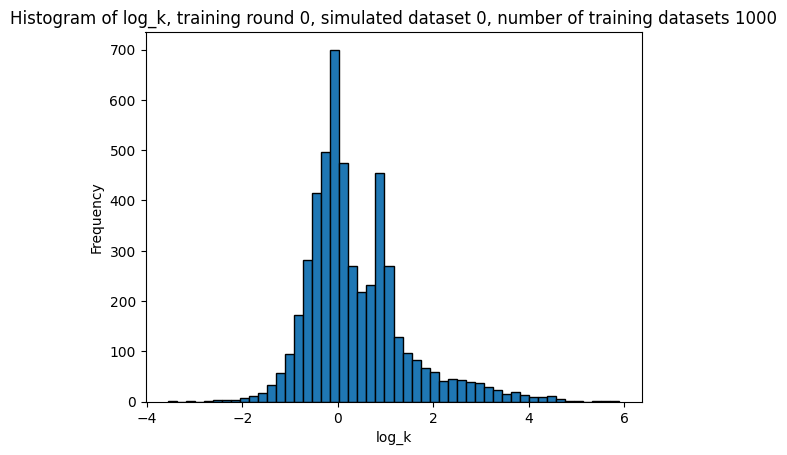

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.9803443551063538
Epoch 2/30, Loss: 0.9511688947677612
Epoch 3/30, Loss: 0.9417669773101807
Epoch 4/30, Loss: 0.933144211769104
Epoch 5/30, Loss: 0.9331188797950745
Epoch 6/30, Loss: 0.9231457114219666
Epoch 7/30, Loss: 0.9116060137748718
Epoch 8/30, Loss: 0.9100976586341858
Epoch 9/30, Loss: 0.9147876501083374
Epoch 10/30, Loss: 0.8995168209075928
Epoch 11/30, Loss: 0.9005533456802368
Epoch 12/30, Loss: 0.9010758996009827
Epoch 13/30, Loss: 0.9006842374801636
Epoch 14/30, Loss: 0.8913933634757996
Epoch 15/30, Loss: 0.8942803740501404
Epoch 16/30, Loss: 0.8864266276359558
Epoch 17/30, Loss: 0.8796889185905457
Epoch 18/30, Loss: 0.9102267622947693
Epoch 19/30, Loss: 0.8781355619430542
Epoch 20/30, Loss: 0.890511691570282
Epoch 21/30, Loss: 0.8752400875091553
Epoch 22/30, Loss: 0.8718342781066895
Epoch 23/30, Loss: 0.8696470856666565
Epoch 24/30, Loss: 0.8649240732192993
Epoch 25/30, Loss: 0.8599720001220703
Epoc

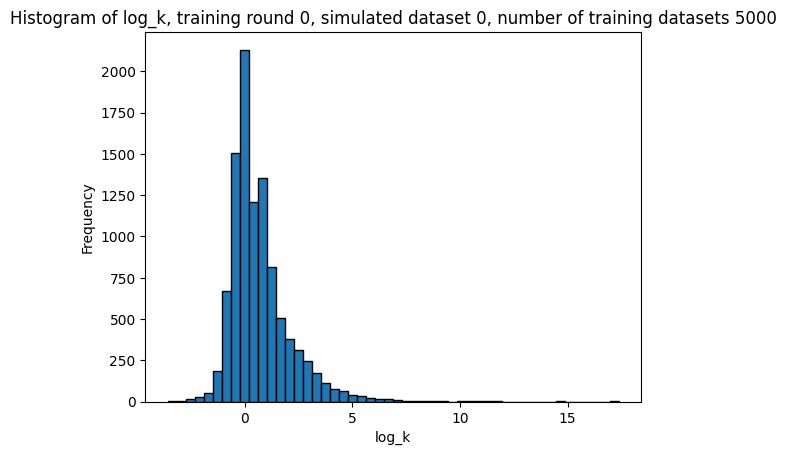

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.955297589302063
Epoch 2/30, Loss: 0.9358797669410706
Epoch 3/30, Loss: 0.9310377836227417
Epoch 4/30, Loss: 0.9158721566200256
Epoch 5/30, Loss: 0.9099140763282776
Epoch 6/30, Loss: 0.9029989838600159
Epoch 7/30, Loss: 0.8959777355194092
Epoch 8/30, Loss: 0.8994511961936951
Epoch 9/30, Loss: 0.8886299133300781
Epoch 10/30, Loss: 0.8855083584785461
Epoch 11/30, Loss: 0.8738896250724792
Epoch 12/30, Loss: 0.94115149974823
Epoch 13/30, Loss: 0.918811023235321
Epoch 14/30, Loss: 0.9009698033332825
Epoch 15/30, Loss: 0.882304310798645
Epoch 16/30, Loss: 0.8813761472702026
Epoch 17/30, Loss: 0.8699966669082642
Epoch 18/30, Loss: 0.8718655109405518
Epoch 19/30, Loss: 0.8621127605438232
Epoch 20/30, Loss: 0.8672763109207153
Epoch 21/30, Loss: 0.8588755130767822
Epoch 22/30, Loss: 0.849850594997406
Epoch 23/30, Loss: 0.8516836762428284
Epoch 24/30, Loss: 0.8593233823776245
Epoch 25/30, Loss: 0.851410984992981
Epoch 26/

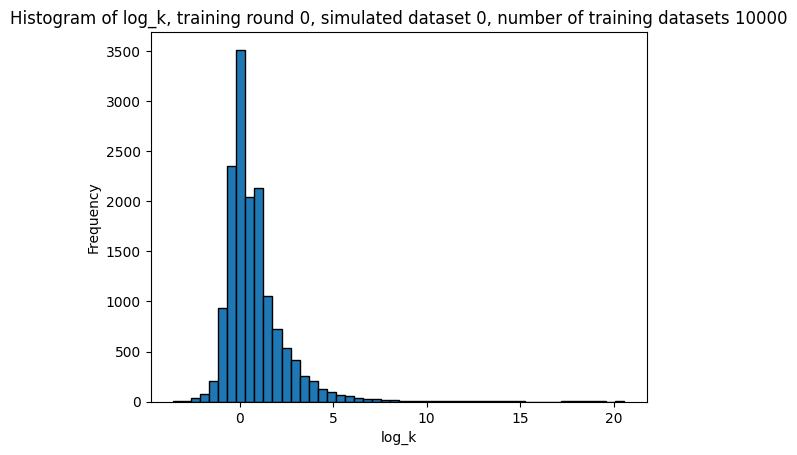

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.928807258605957
Epoch 2/30, Loss: 0.9042264819145203
Epoch 3/30, Loss: 0.8808812499046326
Epoch 4/30, Loss: 0.8671544194221497
Epoch 5/30, Loss: 0.8562546968460083
Epoch 6/30, Loss: 0.8468400239944458


KeyboardInterrupt: 

In [48]:
class optim_p3_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data_plotting(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        # return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

class optim_p4_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data_plotting(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04, -0.001])

    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        # return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            N_iter_filter = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter_filter = 1000
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    # print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:
            
            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_4_plot = self.curve_torch_4(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_4_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

type_N = [10**3, 5 * 10**3, 10**4, 5 * 10**4, 10**5, 5 * 10**5, 10**6]
log_K_array = []
number_simulated_datasets = 1
number_training_rounds = 1
number_validation_datasets = 5000

for N in type_N:

    for k in range(number_simulated_datasets):

        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_poisson(data_path)
        x_tensor = optimizer_class.x_tensor
        array_vector_datasets_3 = []
        for i in range(N):
            theta = optimizer_class.create_priors()
            y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
            y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
            array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

        print("Datasets simulated")

        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p4_poisson(data_path)
        x_tensor = optimizer_class.x_tensor
        array_vector_datasets_4 = []
        for i in range(N):
            theta = optimizer_class.create_priors()
            y_pred_4_rvs_priors = optimizer_class.curve_torch_4(x_tensor, *theta) 
            y_pred_4_rvs_priors_plus_noise = torch.poisson(y_pred_4_rvs_priors)
            array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

        print("Datasets simulated")

        D3 = np.array(array_vector_datasets_3)
        D4 = np.array(array_vector_datasets_4)

        # Produce validation data from i = 4 model
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p4_poisson(data_path)
        x_tensor = optimizer_class.x_tensor
        test_data_4_plus_noise_array = []
        for n in range(number_validation_datasets):
            theta = optimizer_class.create_priors()
            test_data_4 = optimizer_class.curve_torch_4(x_tensor, *theta)
            test_data_4_plus_noise = torch.poisson(test_data_4)
            test_data_4_plus_noise_array.append(test_data_4_plus_noise.detach().numpy())

        X = x_me

        class CustomBinaryClassifierLPop(BinaryClassifierLPop):
            def fit(self, X, y, **kwargs):
                # kwargs['batch_size'] = 128
                kwargs['num_epochs'] = 30
                super().fit(X, y, **kwargs)

        evidence_network = CustomBinaryClassifierLPop(len(X))

        data = np.concatenate((D3, D4))
        labels = np.concatenate((np.zeros(N), np.ones(N)))

        for j in range(number_training_rounds):

            evidence_network.fit(data, labels)

            for n in range(number_validation_datasets):

                log_K = evidence_network.predict(test_data_4_plus_noise_array[n][...,None].T).squeeze()
                print(f"Bayes Factor = {log_K}")
                log_K_array.append(log_K)

            plt.hist(log_K_array, bins=50, edgecolor='black')
            plt.title(f'Histogram of log_k, training round {j}, simulated dataset {k}, number of training datasets {N}')
            plt.xlabel('log_k')
            plt.ylabel('Frequency')
            plt.show()


# Signal detection

A similar method is used to do signal detection instead this time we use a background only model and a background model plus a signal where we think there might be a bump and compare the models using the classifier. First I will do manual detection but this will be automated later to scan a given range and apply signal tests for a given width of signal in each range.

In [75]:
# Using i = 3 model

class optim_p3_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

def gaussian_signal(x, mean, std_dev, amplitude):
    prefactor = amplitude / np.sqrt(2 * np.pi * std_dev**2)
    exponent = -((x - mean)**2) / (2 * std_dev**2)
    return prefactor * np.exp(exponent)

signal_means = [770.867, 908.401, 107.475, 1220.72, 1347.085, 1695.165, 2354]
lower_bounds = [721.172, 850.664, 1035.895, 1181.29, 1261.465, 1587.42, 2133.19]
upper_bounds = [823.187, 938.723, 1106.205, 1261.465, 1392.05, 1810.22, 2513.785]
curve = [115.326, 51.119, 22.146, 11.115, 6.570, 1.79, 0.239]
data_points = [138.689, 59.348, 25.893, 15.22, 7.462, 2.875, 0.518]

for j in range(3):

    # Background only model
    N = 7 * 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Background plus signal model
    signal_number = len(signal_means)
    M = round(N/signal_number)
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3_signal = []

    # For signal have so far chosen to have perceived width of signal to be equal to 2 sigma

    for j in range(len(signal_means)):
        for i in range(M):
            theta = optimizer_class.create_priors()
            y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
            signal_x_range = x_tensor
            signal = gaussian_signal(signal_x_range, mean = signal_means[j], std_dev = (upper_bounds[j] - lower_bounds[j])/4, amplitude = data_points[j] - curve[j])
            y_pred_3_rvs_priors_plus_signal = y_pred_3_rvs_priors + signal
            y_pred_3_rvs_priors_plus_signal_and_noise = torch.poisson(y_pred_3_rvs_priors_plus_signal)
            array_vector_datasets_3_signal.append(y_pred_3_rvs_priors_plus_signal_and_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_3)
    D4 = np.array(array_vector_datasets_3_signal)

    X = x_me

    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            kwargs['num_epochs'] = 30  # Custom number of epochs
            super().fit(X, y, **kwargs)
    
    # internal = 16
    # initial = 130

    evidence_network = CustomBinaryClassifierLPop(len(X))

    # evidence_network = BinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D4))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    for k in range(1):

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 1.0000965595245361
Epoch 2/30, Loss: 1.0000160932540894
Epoch 3/30, Loss: 1.0000190734863281
Epoch 4/30, Loss: 1.000015139579773
Epoch 5/30, Loss: 1.0000145435333252
Epoch 6/30, Loss: 1.000011920928955
Epoch 7/30, Loss: 1.000010371208191
Epoch 8/30, Loss: 1.000011920928955
Epoch 9/30, Loss: 1.000005841255188
Epoch 10/30, Loss: 1.000008463859558
Epoch 11/30, Loss: 1.0000073909759521
Epoch 12/30, Loss: 1.0000097751617432
Epoch 13/30, Loss: 1.0000110864639282
Epoch 14/30, Loss: 1.0000070333480835
Epoch 15/30, Loss: 1.000006914138794
Epoch 16/30, Loss: 1.000007152557373
Epoch 17/30, Loss: 1.0000065565109253
Epoch 18/30, Loss: 1.0000072717666626
Epoch 19/30, Loss: 1.000008225440979
Epoch 20/30, Loss: 1.0000057220458984
Epoch 21/30, Loss: 1.0000065565109253
Epoch 22/30, Loss: 1.0000022649765015
Epoch 23/30, Loss: 1.0000046491622925
Epoch 24/30, Loss: 1.0000042915344238
Epoch 25/30, Loss: 1.0000054836273193
Epoch 26/30

# Testing areas (not in use rn)

## Testing area 1 (countour and interactive contour)

In [ ]:
### Sped up version of class but now for fixd abp0

def curve_torch_3(x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
    c_e_ft = 1
    BW2 = gamma / ((x * 13000 - mz) ** 2 + (gamma ** 2) / 4)
    log_x = torch.log(x)
    curve_ft = BW2 * ((1 - x ** c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
    norm_ft = a_ft / curve_ft.sum()
    return norm_ft * curve_ft

def loglike(y_pred, y, y_err_tensor):
    valid_indices = y_err_tensor > 0
    chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
    return torch.mean(chi_sq)

class optim_p3_fix_abp0:
    def __init__(self, data_path, constant_a, constant_b, constant_p0):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_a = constant_a
        self.constant_b = constant_b
        self.constant_p0 = constant_p0

    def create_priors(self):
        return np.random.uniform(low=[self.constant_a, self.constant_b, self.constant_p0, -7, -1, -0.1], high=[self.constant_a, self.constant_b, self.constant_p0, -1, -0.5, -0.03])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, theta, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i <= 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                if i >= 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta[0], theta[1], theta[2], theta_opt[0], theta_opt[1], theta_opt[2])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i <= 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                if i >= 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta[0], theta[1], theta[2], theta_opt[0], theta_opt[1], theta_opt[2])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            else:
                pass
                # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 2500
            loss_crit = 5
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta[0], theta[1], theta[2], theta_opt[0], theta_opt[1], theta_opt[2])
                loss = self.loglike(y_pred_3, y_tensor, y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                if loss < loss_crit:
                    success = True
                    break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > 5.3:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            theta_final = []

            for i in range(len(theta)):
                if i <= 2:
                    theta_final.append(theta[i])
            for i in range(len(theta)):
                if i <= 2:
                    theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

        if success:
            print(f"Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
        #     # Save results if good

        #     timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        #     filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
        #     filename_theta_final = f"Theta_3_final_{timestamp}.txt"

        #     with open(filename_theta_initial, 'w') as f:
        #         f.write(str(self.theta_final.tolist()))
        #     with open(filename_theta_final, 'w') as f:
        #         f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_np = curve_torch_3(self.x_tensor, self.theta_final[0], self.theta_final[1], self.theta_final[2], self.theta_final[3], self.theta_final[4], self.theta_final[5]).detach().numpy()
            # plt.plot(De_mass, y_pred_3_np)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")

# Pairwise contour plots of loss (loglike() function)

def contour_plot():

    prior_0 = 180000

    # Tensor everything

    theta_0 = torch.tensor(prior_0, dtype=torch.float32)

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p0_ft_lower = -15 # Real is -15 Viewing is -20
    p0_ft_upper = -10 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p0_ft_values = torch.linspace(p0_ft_lower, p0_ft_upper, 20)
    B, P0 = torch.meshgrid(b_ft_values, p0_ft_values)
    loglike_values = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_abp0(data_path, theta_0, b_ft_values[i], p0_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_0, b_ft_values[i], p0_ft_values[j], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")

    # Save file

    def save_loglike_values(loglike_values, b_ft_values, p0_ft_values, filename_prefix='loglike_history'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        b_values_array = []
        p0_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(b_ft_values))):
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'loglikelihood': loglike_values_array
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, b_ft_values, p0_ft_values, filename_prefix='loglike_history')

    # Contour plotting
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P0.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    # print(b_ft_values)
    # print(p0_ft_values)
    # print(B)
    # print(P0)
    # print(loglike_values_np)
    plt.show()
    
    # Scatter Plotting

    b_values_array = []
    p0_values_array = []
    loglike_values_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[j].item())
            loglike_values_array.append(loglike_values[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p0_values_array = np.array(p0_values_array)
    loglike_values_array = np.array(loglike_values_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=0, vmax=200)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 100

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_val, 1)), fontsize=9, color='red')
    
    plt.show()

# Call contour plot function

contour_plot()


/opt/homebrew/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Initial Loss = 14.499194145202637
Final loss = 4.97276095256275, Number of iterations = 236
Calculated loglike_values[0, 0]
Initial Loss = 3.0020503997802734
Final loss = 3.002050579637366, Number of iterations = 1
Calculated loglike_values[0, 1]
Initial Loss = 18.03022575378418
Final loss = 4.989245038994372, Number of iterations = 179
Calculated loglike_values[0, 2]
Initial Loss = 22.889698028564453
Final loss = 4.562416827243167, Number of iterations = 2
Calculated loglike_values[0, 3]
Initial Loss = 23.95747184753418
Final loss = 4.996158234424199, Number of iterations = 187
Calculated loglike_values[0, 4]
Initial Loss = 7.649322509765625
Final loss = 4.996157076553314, Number of iterations = 19
Calculated loglike_values[0, 5]
Initial Loss = 10.765313148498535
Final loss = 4.970135328162962, Number of iterations = 39
Calculated loglike_values[0, 6]
Initial Loss = 10.147253036499023
Final loss = 4.982616617772652, Number of iterations = 185
Calculated loglike_values[0, 7]
Initial Lo

KeyboardInterrupt: 

[[1. 1. 3. 3.]
 [1. 1. 3. 3.]
 [1. 1. 3. 3.]
 [1. 1. 3. 3.]]
[[-15. -15. -15. -15.]
 [-10. -10. -10. -10.]
 [-15. -15. -15. -15.]
 [-10. -10. -10. -10.]]
[15629.19335938   451.95657349  3324.58300781   742.27453613]


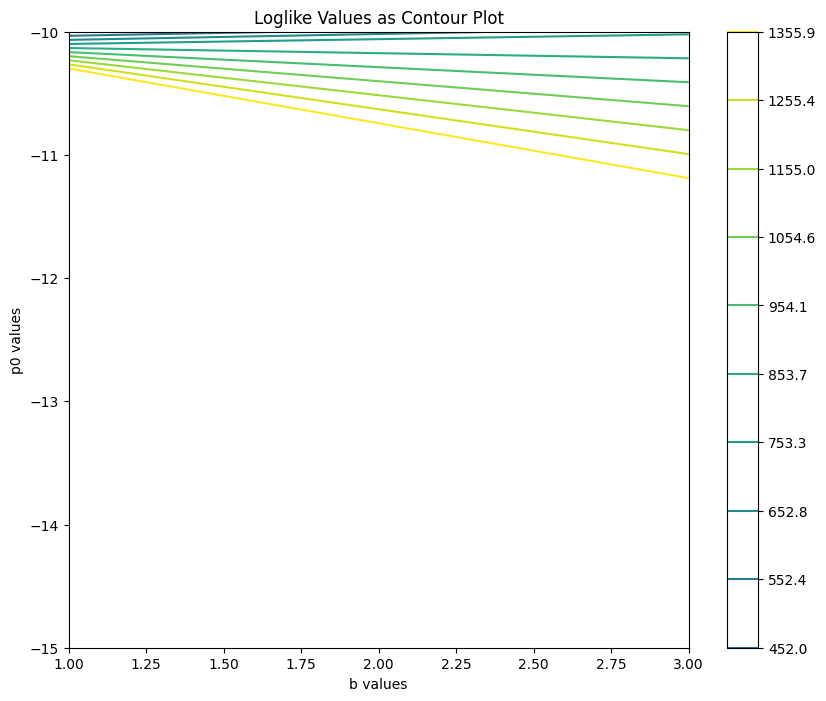

In [ ]:
def replot_contour(filename):
    
    data = pd.read_csv(filename)

    b_values = data['b_values'].values
    p0_values = data['p0_values'].values
    loglike_values = data['loglikelihood'].values

    def unique_ordered(arr):
        # Initialize an empty list to keep track of unique items
        unique_list = []
        # Iterate over each item in the array
        for item in arr:
            # If the item is not already in the list, append it
            if item not in unique_list:
                unique_list.append(item)
        # Convert the list back to a numpy array and return
        return np.array(unique_list)
        

    # Since the original data might not be in a grid form suitable for contour plots,
    # we need to create a grid. Assuming b_values and p0_values are sorted and unique:
    b_values_shape = unique_ordered(b_values)
    b_values = b_values.reshape(len(b_values_shape), len(b_values_shape))
    p0_values = p0_values.reshape(len(b_values_shape), len(b_values_shape))

    B, P0 = np.meshgrid(b_values, p0_values)

    print(B)
    print(P0)
    print(loglike_values)
    
    # Reshape loglikelihood to match the shape of B and P0 for contour plotting
    loglike_grid = loglike_values.reshape(len(b_values_shape), len(b_values_shape))

    # Contour plotting
    plt.figure(figsize=(10, 8))
    levels = np.linspace(loglike_grid.min(), loglike_grid.min()*3, num=10)
    contour = plt.contour(b_values, p0_values, loglike_grid, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()

replot_contour('loglike_history_20240229_004748.csv')

In [ ]:
def int_contour(filename):# Load the data

    data = pd.read_csv(filename)

    b_values = data['b_values'].values
    p0_values = data['p0_values'].values
    loglike_values = data['loglikelihood'].values

    def unique_ordered(arr):
        # Initialize an empty list to keep track of unique items
        unique_list = []
        # Iterate over each item in the array
        for item in arr:
            for i in range(len(arr)):
                if arr[i] == item:
                    # If the item is not already in the list, append it
                    if item not in unique_list:
                        unique_list.append(item)
        # Convert the list back to a numpy array and return
        return np.array(unique_list)
        

    # Since the original data might not be in a grid form suitable for contour plots,
    # we need to create a grid. Assuming b_values and p0_values are sorted and unique:
    b_values_shape = unique_ordered(b_values)
    # b_values = b_values.reshape(len(b_values_shape), len(b_values_shape))
    # p0_values = p0_values.reshape(len(b_values_shape), len(b_values_shape))
    b_values = unique_ordered(b_values)
    p0_values = unique_ordered(p0_values)

    B, P0 = np.meshgrid(b_values, p0_values)
    
    # Reshape loglikelihood to match the shape of B and P0 for contour plotting
    loglike_grid = loglike_values.reshape(len(b_values_shape), len(b_values_shape))

    fig = go.Figure(data=[go.Surface(z=-loglike_grid, x=B, y=P0)])

    # Customizing the layout
    fig.update_layout(
        title='Interactive 3D Plot of Log-Likelihood',
        autosize=False,
        width=800, 
        height=800,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            xaxis_title='b values',
            yaxis_title='p0 values',
            zaxis_title='- Log-Likelihood',))
            # zaxis=dict(range=[-4, 0])))

    fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

    # Update scenes for better 3D interaction controls

    fig.update_scenes(
        aspectratio=dict(x=1, y=1, z=0.7),
        camera_eye=dict(x=1.25, y=1.25, z=1.25)
    )

    fig.show()

    print(b_values)
    print(p0_values)
    print(loglike_grid)

int_contour('loglike_history_20240229_060044_IMP_b1to5_p0-15to-10.csv')

[1. 3.]
[-15. -10.]
[[15629.19335938   451.95657349]
 [ 3324.58300781   742.27453613]]


In [ ]:
def int_contour(filename):# Load the data

    data = pd.read_csv(filename)

    b_values = data['b_values'].values
    p0_values = data['p0_values'].values
    loglike_values = data['loglikelihood'].values

    def unique_ordered(arr):
        # Initialize an empty list to keep track of unique items
        unique_list = []
        # Iterate over each item in the array
        for item in arr:
            # If the item is not already in the list, append it
            if item not in unique_list:
                unique_list.append(item)
        # Convert the list back to a numpy array and return
        return np.array(unique_list)
        

    # Since the original data might not be in a grid form suitable for contour plots,
    # we need to create a grid. Assuming b_values and p0_values are sorted and unique:
    b_values_shape = unique_ordered(b_values)
    b_values = b_values.reshape(len(b_values_shape), len(b_values_shape))
    p0_values = p0_values.reshape(len(b_values_shape), len(b_values_shape))
    
    # Reshape loglikelihood to match the shape of B and P0 for contour plotting
    loglike_grid = loglike_values.reshape(len(b_values_shape), len(b_values_shape))

    fig = go.Figure(data=[go.Surface(z=-loglike_grid, x=b_values, y=p0_values, cmin=-100, cmax=0)])

    # Customizing the layout
    fig.update_layout(
        title='Interactive 3D Plot of Log-Likelihood',
        autosize=False,
        width=800, 
        height=800,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            xaxis_title='b values',
            yaxis_title='p0 values',
            zaxis_title='- Log-Likelihood',))
            # zaxis=dict(range=[-8, 0])))

    fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

    # Update scenes for better 3D interaction controls

    fig.update_scenes(
        aspectratio=dict(x=1, y=1, z=0.7),
        camera_eye=dict(x=1.25, y=1.25, z=1.25))

    fig.show()

int_contour('loglike_history_20240229_060044_IMP_b1to5_p0-15to-10.csv')

In [ ]:
# Load the data
filename = 'loglike_history_20240227_112528_IMP_2_b3to5.5_p0-14to-11.csv'  # Update this to your actual filename
data = pd.read_csv(filename)

b_values = data['b_values'].values
b_values = b_values[::-1]
p0_values = data['p0_values'].values
p0_values = p0_values[::-1]
loglike_values = data['loglikelihood'].values
loglike_values = loglike_values[::-1]

# Assuming your b_values and p0_values are already grid-like, reshape them
unique_b = np.unique(b_values)
unique_p0 = np.unique(p0_values)
B, P0 = np.meshgrid(unique_b, unique_p0)

# Reshape loglike_values similarly
loglike_values = loglike_values.reshape(B.shape)

# # Create the plot
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D contour
# levels = np.linspace(loglike_values.min(), 200, num=1000)
# surf = ax.contour3D(B, P0, -loglike_values, levels=levels, cmap='viridis', vmin=0, vmax=200, edgecolor='none', rstride=1, cstride=1, linewidth=0, antialiased=False)
# fig.colorbar(surf)

# ax.set_xlabel('b values')
# ax.set_ylabel('p0 values')
# ax.set_zlabel('Log-Likelihood')
# ax.set_title('3D Contour Plot of Log-Likelihood against b and p0')
# ax.set_zlim(bottom=0, top=200)

fig = go.Figure(data=[go.Surface(z=-loglike_values, x=B, y=P0, cmin=-4, cmax=0)])

# Customizing the layout
fig.update_layout(
    title='Interactive 3D Plot of Log-Likelihood',
    autosize=False,
    width=800, 
    height=800,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='b values',
        yaxis_title='p0 values',
        zaxis_title='- Log-Likelihood',
        zaxis=dict(range=[-4, 0])))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

# Update scenes for better 3D interaction controls

fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    camera_eye=dict(x=1.25, y=1.25, z=1.25)
)

fig.show()

In [ ]:
# Load the data
filename = 'loglike_history_20240227_120001_IMP_3_b5.5to8_p0-14to-11.csv'  # Update this to your actual filename
data = pd.read_csv(filename)

b_values = data['b_values'].values
p0_values = data['p0_values'].values
loglike_values = data['loglikelihood'].values

# Assuming your b_values and p0_values are already grid-like, reshape them
unique_b = np.unique(b_values)
unique_p0 = np.unique(p0_values)
B, P0 = np.meshgrid(unique_b, unique_p0)

# Reshape loglike_values similarly
loglike_values = loglike_values.reshape(B.shape)

# # Create the plot
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D contour
# levels = np.linspace(loglike_values.min(), 200, num=1000)
# surf = ax.contour3D(B, P0, -loglike_values, levels=levels, cmap='viridis', vmin=0, vmax=200, edgecolor='none', rstride=1, cstride=1, linewidth=0, antialiased=False)
# fig.colorbar(surf)

# ax.set_xlabel('b values')
# ax.set_ylabel('p0 values')
# ax.set_zlabel('Log-Likelihood')
# ax.set_title('3D Contour Plot of Log-Likelihood against b and p0')
# ax.set_zlim(bottom=0, top=200)

fig = go.Figure(data=[go.Surface(z=loglike_values, x=B, y=P0, cmin=-4, cmax=0)])

# Customizing the layout
fig.update_layout(
    title='Interactive 3D Plot of Log-Likelihood',
    autosize=False,
    width=800, 
    height=800,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='b values',
        yaxis_title='p0 values',
        zaxis_title='Log-Likelihood',
        zaxis=dict(range=[9, 0])))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

# Update scenes for better 3D interaction controls

fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    camera_eye=dict(x=1.25, y=1.25, z=1.25)
)

fig.show()

## Testing area 2 (Scanning b against loglikelihood, optimising all others)

Final loss = 1012.0423969775399, Number of iterations = 5000
Calculated loglike_values[0]
Final loss = 1846.179174687742, Number of iterations = 5000
Calculated loglike_values[1]
Final loss = 1231.1938654544858, Number of iterations = 5000
Calculated loglike_values[2]
Final loss = 1278.323215043453, Number of iterations = 5000
Calculated loglike_values[3]
Final loss = 1474.604621629812, Number of iterations = 5000
Calculated loglike_values[4]
Final loss = 1165.169770722607, Number of iterations = 5000
Calculated loglike_values[5]
Final loss = 955.3012160268364, Number of iterations = 5000
Calculated loglike_values[6]
Final loss = 1317.8890843504091, Number of iterations = 5000
Calculated loglike_values[7]
Final loss = 1827.6877121046525, Number of iterations = 5000
Calculated loglike_values[8]
Final loss = 866.0620625747374, Number of iterations = 5000
Calculated loglike_values[9]
Final loss = 1692.8675771929165, Number of iterations = 5000
Calculated loglike_values[10]
Final loss = 83

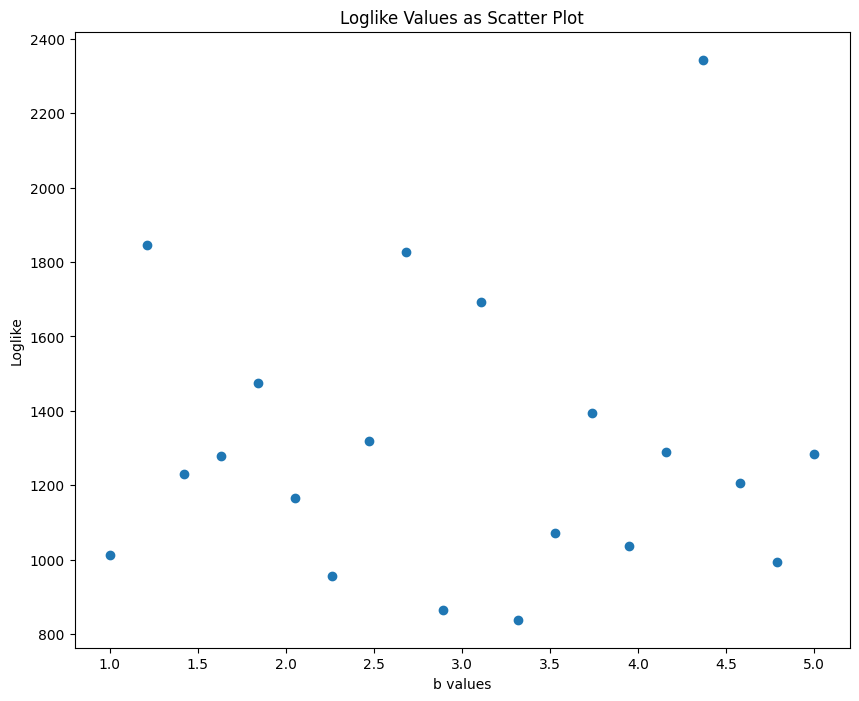

In [ ]:
class optim_p3_only_abp0:
    def __init__(self, data_path, constant_b):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b

    def create_priors(self):
        return np.random.uniform(low=[10**5, self.constant_b, -15], high=[2 * 10**5, self.constant_b, -10])
    
    def curve_torch_3(self, x, a_ft, b_ft, p0_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 10**5

    def adjust_theta_3(self, theta, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 5000
            loss_crit = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1])
                loss = self.loglike(y_pred_3, y_tensor, y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                # if N_iter == 1000 and loss > 5.3:
                #     # print("Loss too high. Starting again.")
                #     break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta_opt[i-1])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            print(f"Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

# Pairwise contour plots of loss (loglike() function)

def b_loglike_scan_only_abp0():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    loglike_values = torch.zeros(b_ft_values.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_only_abp0(data_path, b_ft_values[i])
        optimizer_class.run()
        theta_final = optimizer_class.theta_final
        y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], b_ft_values[i], theta_final[2])
        loglike_values[i] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
        # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
        print(f"Calculated loglike_values{[i]}")

    # Save file

    def save_loglike_values(loglike_values, b_ft_values, filename_prefix='loglike_history_bvsloglike'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        b_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            b_values_array.append(b_ft_values[i].item())
            loglike_values_array.append(loglike_values[i].item())
    
        b_values_array = np.array(b_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'b_values': b_values_array,
            'loglikelihood': loglike_values_array
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, b_ft_values, filename_prefix='loglike_history_bvsloglike')
    
    # Scatter Plotting

    b_values_array = []
    loglike_values_array = []
    
    for i in range(len(b_ft_values)):
        b_values_array.append(b_ft_values[i].item())
        loglike_values_array.append(loglike_values[i].item())
    
    b_values_array = np.array(b_values_array)
    loglike_values_array = np.array(loglike_values_array)

    plt.figure(figsize=(10, 8))
    plt.scatter(b_values_array, loglike_values_array)
    plt.xlabel('b values')
    plt.ylabel('Loglike')
    plt.title('Loglike Values as Scatter Plot')

    # critical_loglike_value = 100

    # # Iterate over all points
    # for i, loglike_val in enumerate(loglike_values_array):
    #     if loglike_val < critical_loglike_value:
    #         plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_val, 1)), fontsize=9, color='red')
    
    plt.show()

# Call contour plot function

b_loglike_scan_only_abp0()

Final loss = 2157.3536024904483, Number of iterations = 5000
Calculated loglike_values[0], Loglike = 2157.353515625, a = 132129.234375
Final loss = 1949.985483797782, Number of iterations = 5000
Calculated loglike_values[1], Loglike = 1949.9854736328125, a = 130857.75
Final loss = 3642.0852295636923, Number of iterations = 5000
Calculated loglike_values[2], Loglike = 3642.085205078125, a = 197782.140625
Final loss = 2111.744386699823, Number of iterations = 5000
Calculated loglike_values[3], Loglike = 2111.744384765625, a = 155979.921875
Final loss = 2480.5108436073697, Number of iterations = 5000
Calculated loglike_values[4], Loglike = 2480.5107421875, a = 179319.328125
Final loss = 1675.7859829143938, Number of iterations = 5000
Calculated loglike_values[5], Loglike = 1675.7860107421875, a = 150462.515625
Final loss = 1353.4671153444376, Number of iterations = 5000
Calculated loglike_values[6], Loglike = 1353.4671630859375, a = 135561.546875
Final loss = 1913.1855089191797, Number of

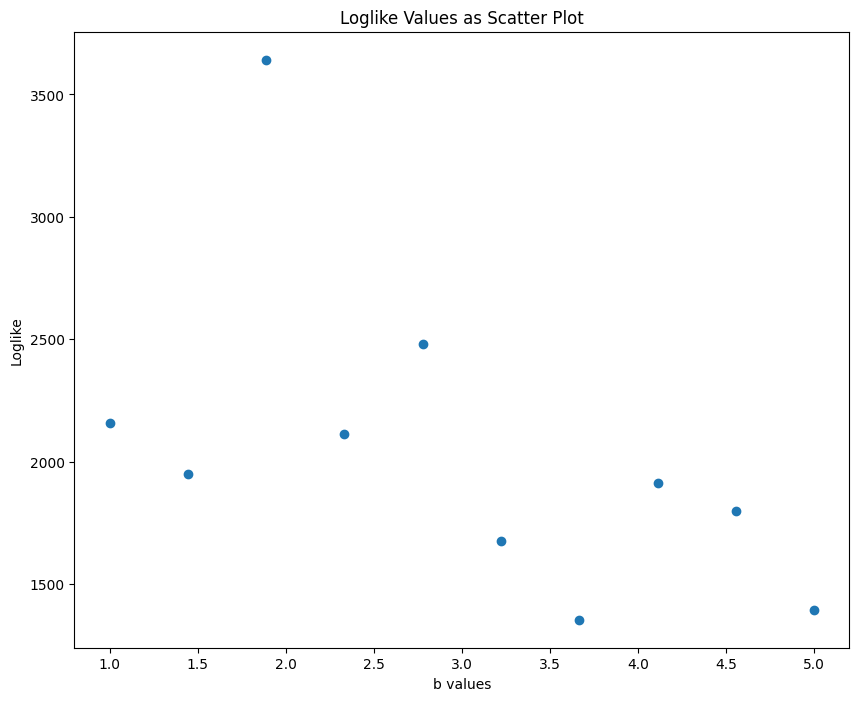

In [ ]:
class optim_p3_only_ab:
    def __init__(self, data_path, constant_b):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b

    def create_priors(self):
        return np.random.uniform(low=[10**5, self.constant_b], high=[2 * 10**5, self.constant_b])
    
    def curve_torch_3(self, x, a_ft, b_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 10**5

    def adjust_theta_3(self, theta, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 5000
            loss_crit = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1])
                loss = self.loglike(y_pred_3, y_tensor, y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                # if N_iter == 1000 and loss > 5.3:
                #     # print("Loss too high. Starting again.")
                #     break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            print(f"Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

# Pairwise contour plots of loss (loglike() function)

def b_loglike_scan_only_ab():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 10)
    loglike_values = torch.zeros(b_ft_values.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_only_ab(data_path, b_ft_values[i])
        optimizer_class.run()
        theta_final = optimizer_class.theta_final
        y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], b_ft_values[i])
        loglike_values[i] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
        # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
        print(f"Calculated loglike_values{[i]}, Loglike = {loglike_values[i]}, a = {theta_final[0]}")

    # Save file

    def save_loglike_values(loglike_values, b_ft_values, filename_prefix='loglike_history_bvsloglike'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        b_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            b_values_array.append(b_ft_values[i].item())
            loglike_values_array.append(loglike_values[i].item())
    
        b_values_array = np.array(b_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'b_values': b_values_array,
            'loglikelihood': loglike_values_array
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, b_ft_values, filename_prefix='loglike_history_bvsloglike')
    
    # Scatter Plotting

    b_values_array = []
    loglike_values_array = []
    
    for i in range(len(b_ft_values)):
        b_values_array.append(b_ft_values[i].item())
        loglike_values_array.append(loglike_values[i].item())
    
    b_values_array = np.array(b_values_array)
    loglike_values_array = np.array(loglike_values_array)

    plt.figure(figsize=(10, 8))
    plt.scatter(b_values_array, loglike_values_array)
    plt.xlabel('b values')
    plt.ylabel('Loglike')
    plt.title('Loglike Values as Scatter Plot')

    # critical_loglike_value = 100

    # # Iterate over all points
    # for i, loglike_val in enumerate(loglike_values_array):
    #     if loglike_val < critical_loglike_value:
    #         plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_val, 1)), fontsize=9, color='red')
    
    plt.show()

# Call contour plot function

b_loglike_scan_only_ab()

Calculated loglike_values[0]
Calculated loglike_values[1]
Calculated loglike_values[2]
Calculated loglike_values[3]
Calculated loglike_values[4]
Calculated loglike_values[5]
Calculated loglike_values[6]
Calculated loglike_values[7]
Calculated loglike_values[8]
Calculated loglike_values[9]


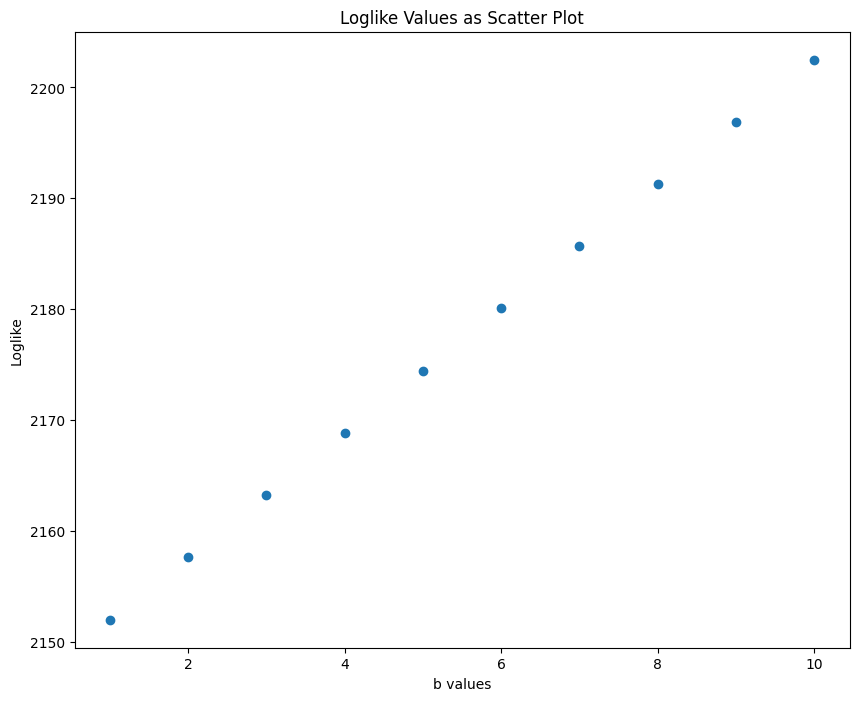

interactive(children=(FloatSlider(value=-10.0, continuous_update=False, description='p0', max=0.0, min=-15.0),…

<function __main__.b_loglike_scan_fix_a_slider_p0(p0)>

In [ ]:
class optim_p3_only_b:
    def __init__(self, data_path, constant_a, constant_b, p0):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_a = constant_a
        self.p0 = p0

    def create_priors(self):
        return np.random.uniform(low=[self.constant_b], high=[self.constant_b])
    
    def curve_torch_3(self, x, a_ft, b_ft, p0):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** p0
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

# Pairwise contour plots of loss (loglike() function)

def b_loglike_scan_fix_a_slider_p0(p0):

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 10 # Real is 1 Viewing is 

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 10)
    loglike_values = torch.zeros(b_ft_values.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_only_b(data_path, 180000, b_ft_values[i], p0)
        # optimizer_class.run()
        # theta_final = optimizer_class.theta_final
        y_pred_3_b= optimizer_class.curve_torch_3(x_tensor, 180000, b_ft_values[i], p0)
        loglike_values[i] = optimizer_class.loglike(y_pred_3_b, y_tensor, y_err_tensor)
        # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
        print(f"Calculated loglike_values{[i]}")
    
    # Scatter Plotting

    b_values_array = []
    loglike_values_array = []
    
    for i in range(len(b_ft_values)):
        b_values_array.append(b_ft_values[i].item())
        loglike_values_array.append(loglike_values[i].item())
    
    b_values_array = np.array(b_values_array)
    loglike_values_array = np.array(loglike_values_array)

    plt.figure(figsize=(10, 8))
    plt.scatter(b_values_array, loglike_values_array)
    plt.xlabel('b values')
    plt.ylabel('Loglike')
    plt.title('Loglike Values as Scatter Plot')

# Call contour plot function

b_loglike_scan_fix_a_slider_p0(-10)
interact(b_loglike_scan_fix_a_slider_p0, p0=FloatSlider(value=-10, min=-15, max=0, step=0.1, continuous_update=False))